# Tools for Modern Macroeconometrics

## Assignment 4: State Space model

### Martin Konvičný

In [365]:
if (!require(pdfetch)) install.packages('pdfetch')
if (!require(tsbox)) install.packages('tsbox')
if (!require(dlm)) install.packages('dlm')
if (!require(tseries)) install.packages('tseries')
if (!require(forecast)) install.packages('forecast')

library(pdfetch) # data
library(tsbox) # from xts to ts format
library(forecast) # (s)arima ( for the third part of the assignment)
library(dlm) # for the second part
library(tseries)

options(repr.plot.width=18, repr.plot.height=8)

In [160]:
cpi <- pdfetch_EUROSTAT("prc_hicp_midx", FREQ="M", UNIT="I15", COICOP = "CP00", GEO="NO") 

I decided to analyze Norwegian inflation since 1996 published by Eurostat. The Norwegian monetary policy target is annual consumer price inflation of close to 2 percent over time. For prediction, they use the CPI adjusted for tax changes and excluding energy products.

           M.I15.CP00.NO
1996-01-31          69.2
1996-02-29          69.3
1996-03-31          69.5
1996-04-30          69.7
1996-05-31          69.9
1996-06-30          70.0

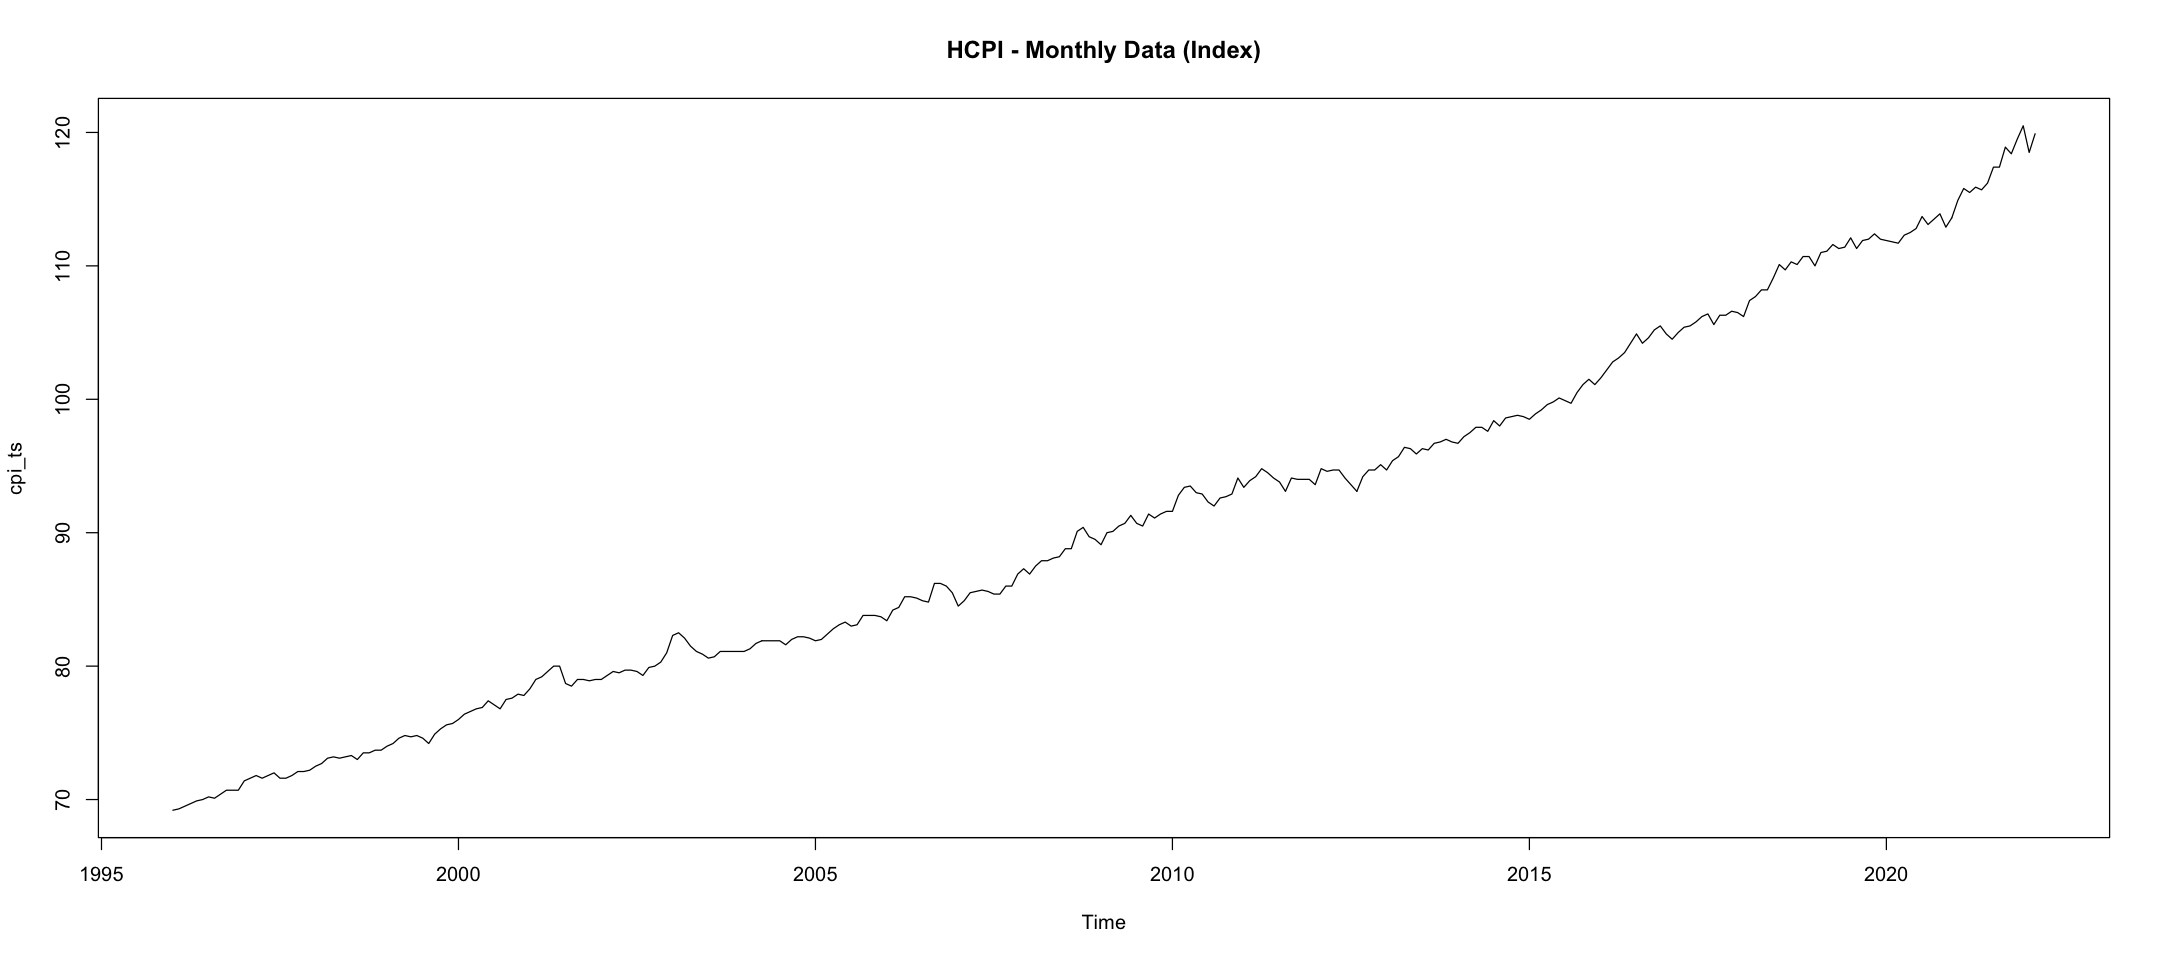

In [161]:
head(cpi)
x <- ts_first_of_period(cpi) # xts to ts 
cpi_ts <- ts_ts(x)
plot.ts(cpi_ts, main= "HCPI - Monthly Data (Index)")

The index seems to grow linearly over time as the local central bank closely monitor the situation and keep the rate around the target.

I will perform analysis on the month-on-month changes, so I transform the data. Surprisingly, there was no big increasing in last months, while inflation was rising worldwide. 

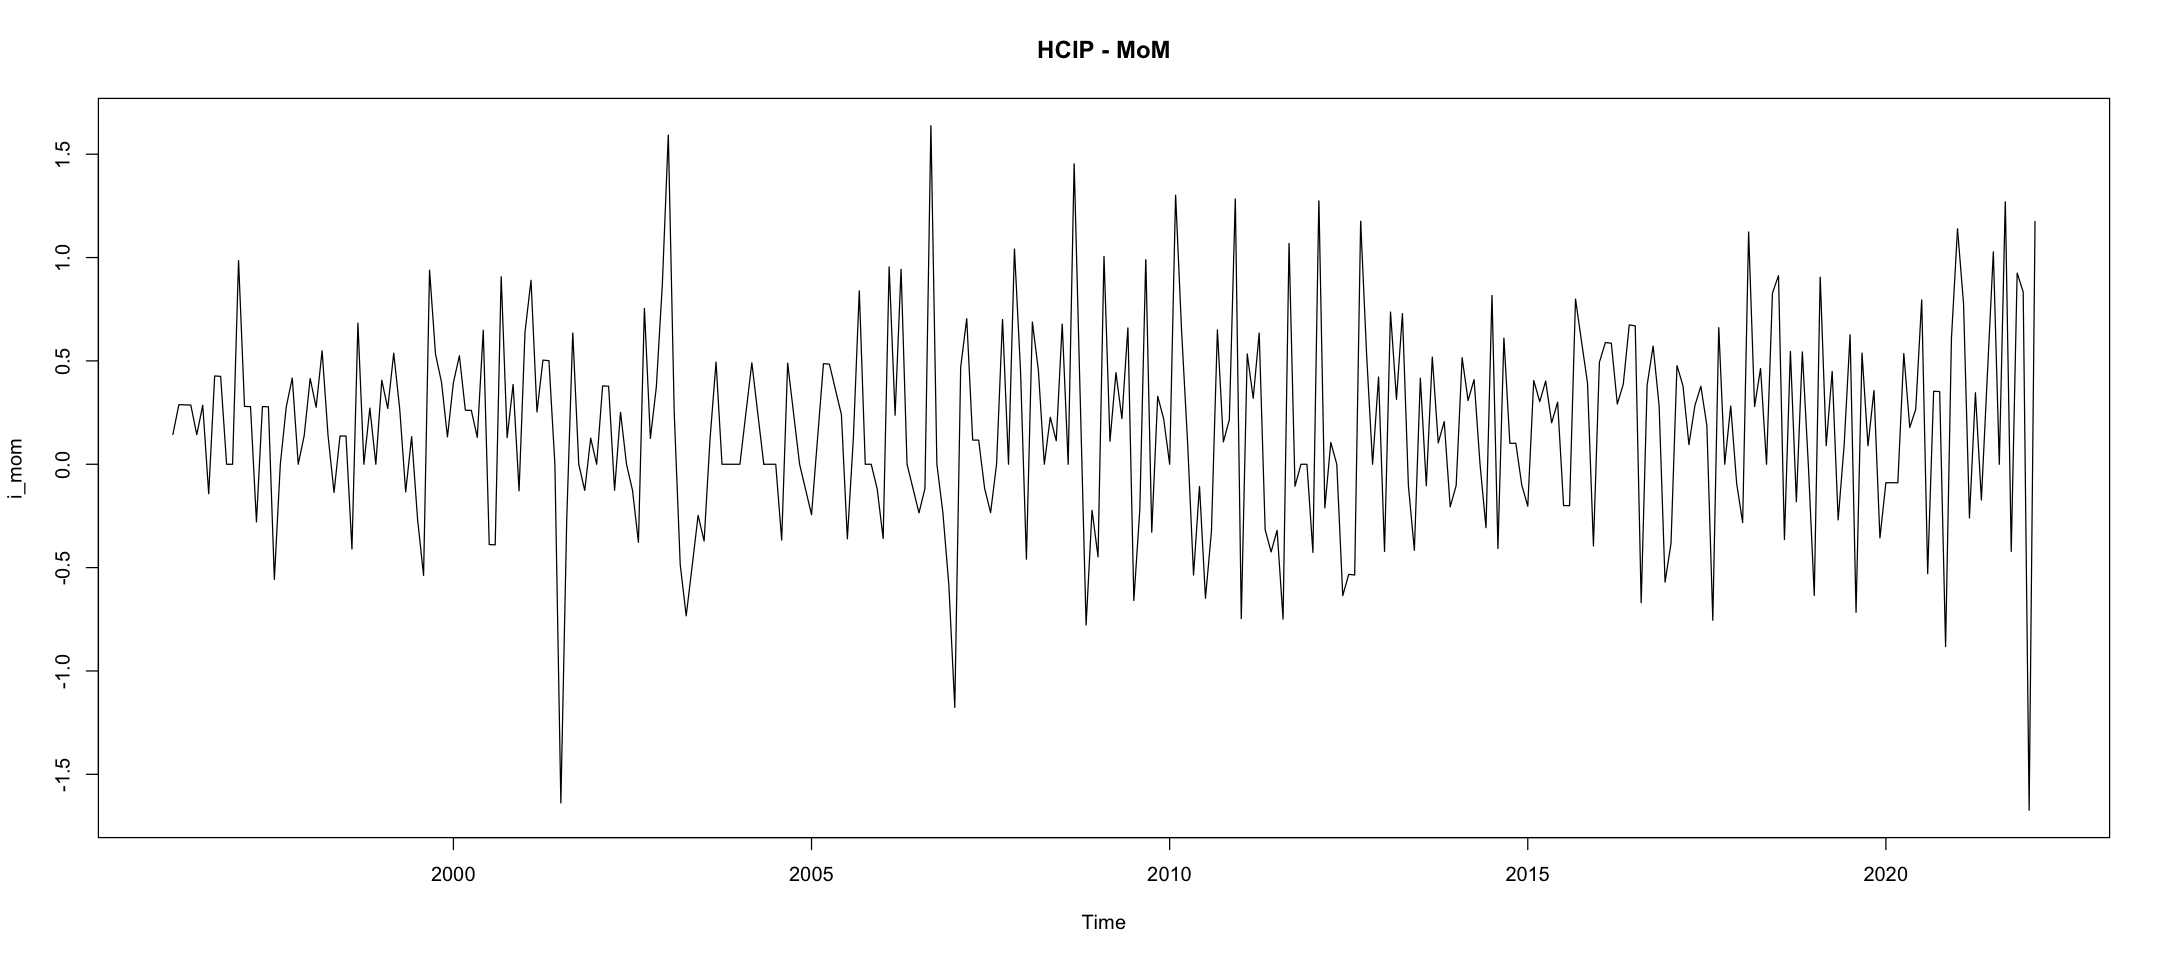

In [162]:
i_mom <- diff(log(cpi_ts) * 100, lag = 1)
plot.ts(i_mom, main = "HCIP - MoM")

**1. Estimate the local level model and the basic structural model using StructTS function, and make a forecast for 2 years ahead.**

In [163]:
# local level model
ll_model <- StructTS(i_mom, type="level")
ll_model

# basic structural model
bs_model <- StructTS(i_mom, type="BSM")
bs_model


Call:
StructTS(x = i_mom, type = "level")

Variances:
  level  epsilon  
 0.0000   0.2384  


Call:
StructTS(x = i_mom, type = "BSM")

Variances:
   level     slope      seas   epsilon  
0.000000  0.000000  0.005051  0.139851  

In the local level model, there is zero level. The volatility in the data is captured by the epsilon. However, the volatility in data is relatively small, and therefore, the epsilon value is also relatively small.

In the basic structural model, part of residuals is explained by seasonality. Therefore, the epsilon value is even smaller.

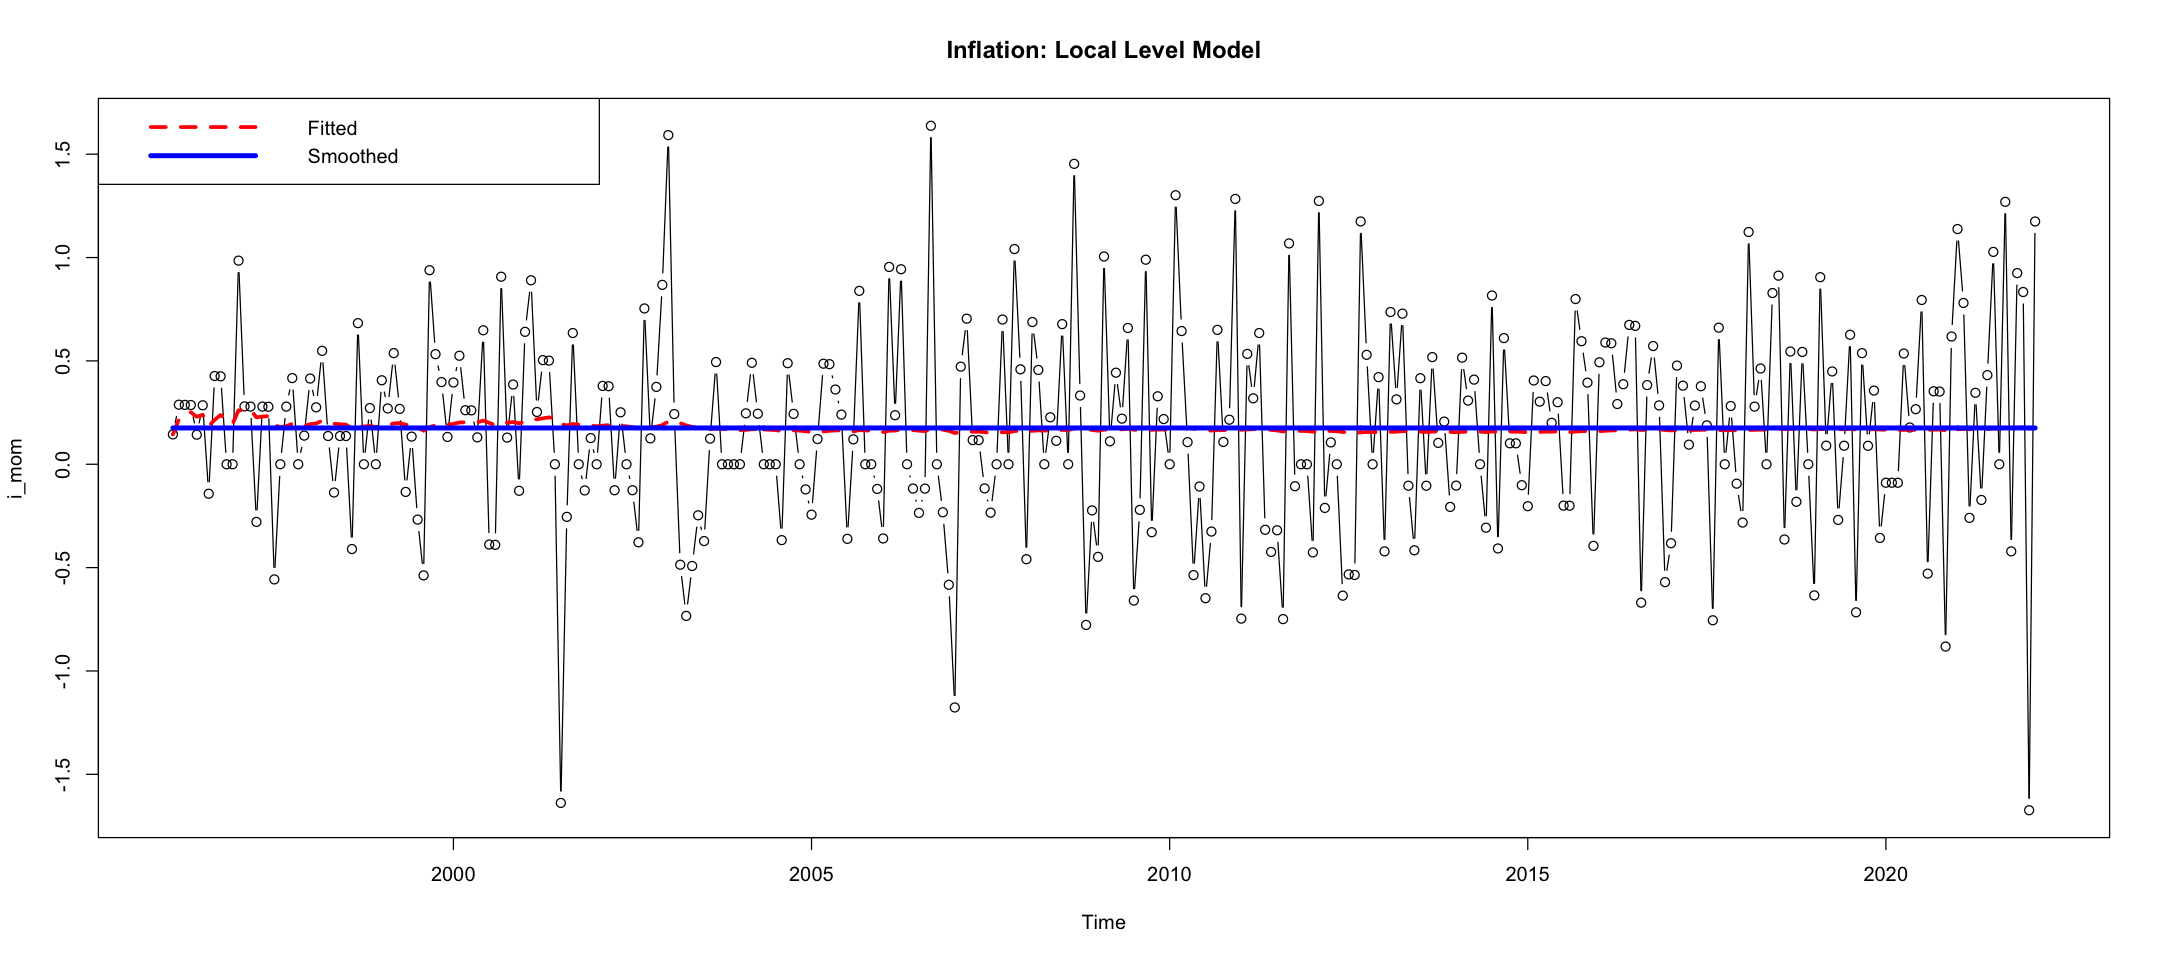

In [216]:
plot(i_mom, type = "b", main="Inflation: Local Level Model")
lines(fitted(ll_model), lty = "dashed", lwd = 3, col = "red")  # fitted
lines(tsSmooth(ll_model), lwd = 4, col = "blue") #smoothed
legend("topleft", legend=c("Fitted", "Smoothed"), col=c("red", "blue"), lwd = 3:4, lty = c("dashed", "solid"))

The fitted values are almost identical to the smoothed straight line. On average, the deviations from the target roughly cancel out over time. The smoothed curve has small positive value. Based on this, it seems that central bank is succesfull at achieving its inflation 2% target.


	Shapiro-Wilk normality test

data:  ll_model$residuals
W = 0.98929, p-value = 0.02122



	Box-Ljung test

data:  ll_model$residuals
X-squared = 86.312, df = 10, p-value = 2.875e-14


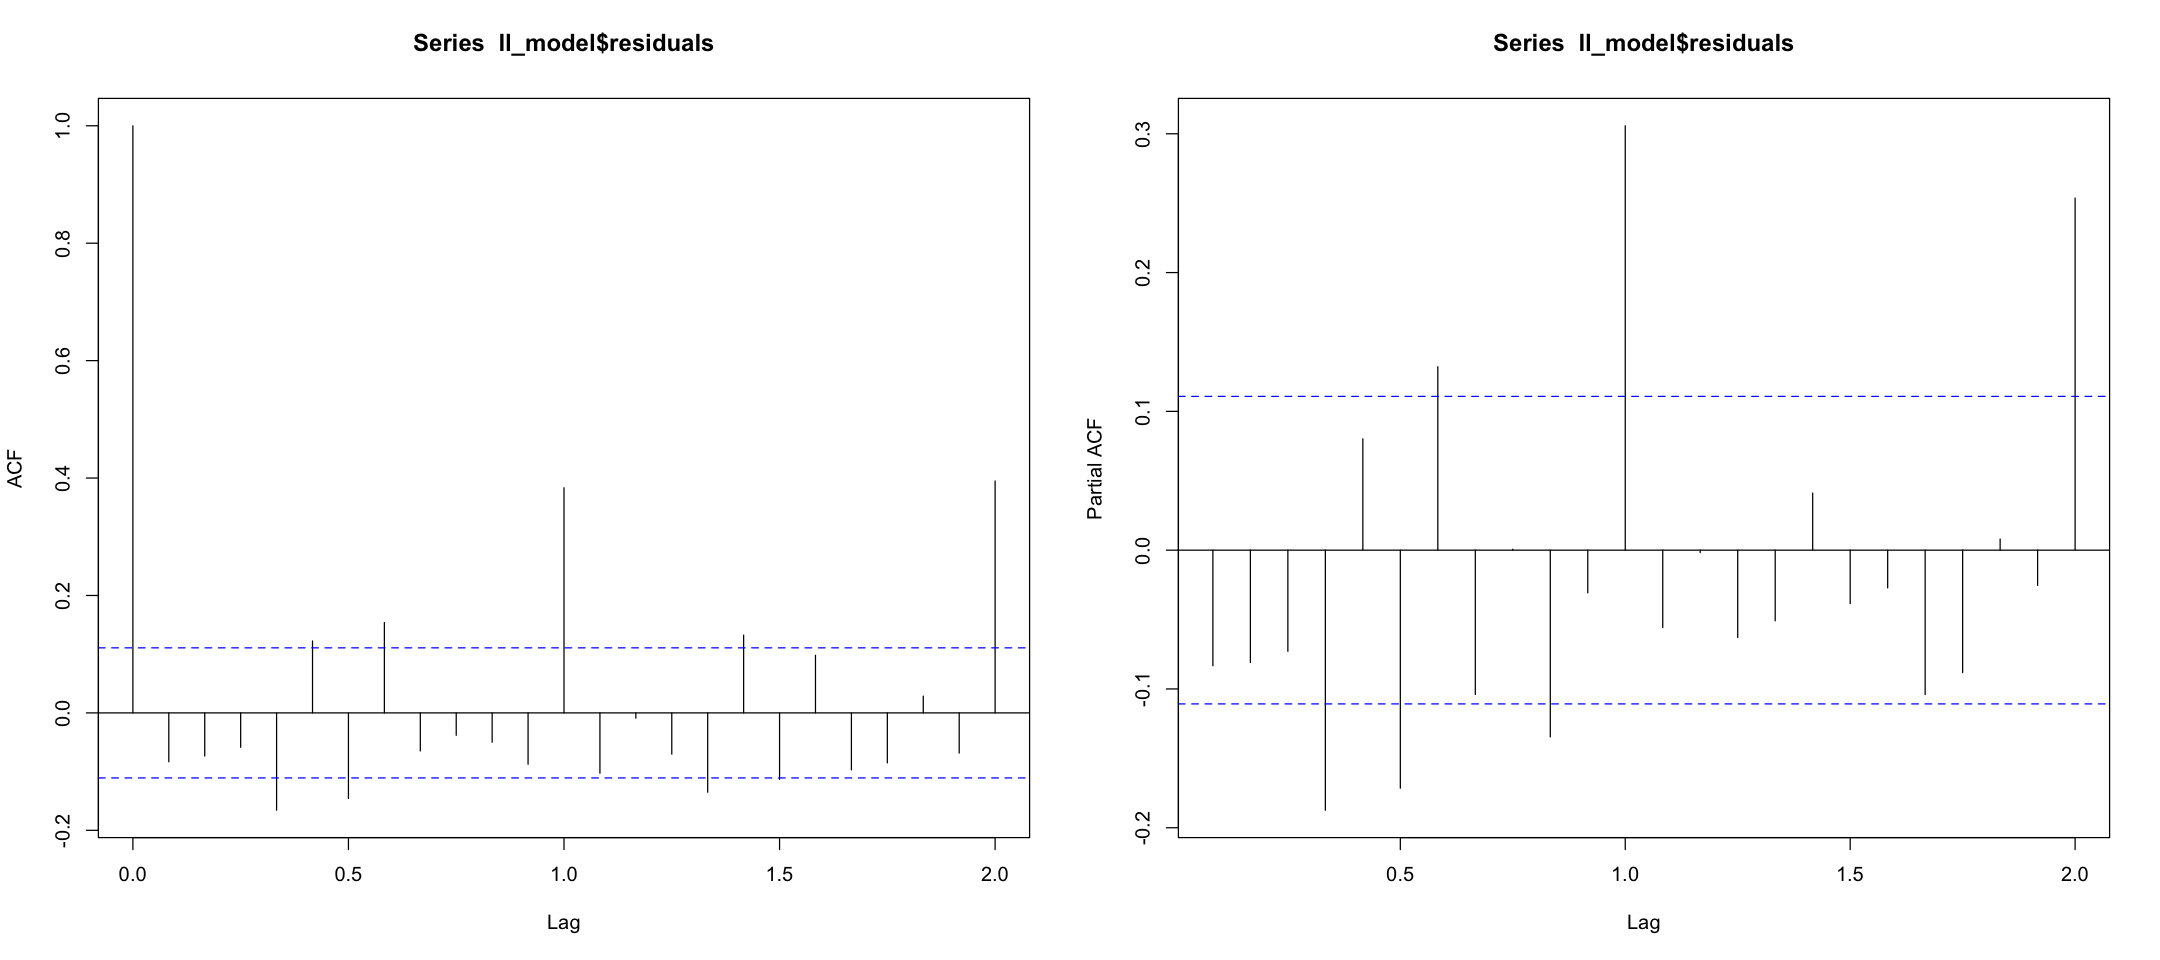

In [321]:
# diagnostics
par(mfrow = c(1, 2))
acf(ll_model$residuals)
pacf(ll_model$residuals)
shapiro.test(ll_model$residuals)
Box.test(ll_model$residuals, lag = 12, type = "Ljung", fitdf = 2)

The diagnostics of the residuals provides ambiguous evidence of remaining serial correlation. According to Ljung-Box and Shapiro-wilk test, there is no strong evidence of presence of serial correlation and residuals' distribution is relatively normal. On the other hand, ACF and PACF plots indicates that residuals do not closely follows white noise. The seasonality element that is not explained in the model may play a role. Let's check whether the basic structural model produces better fit.

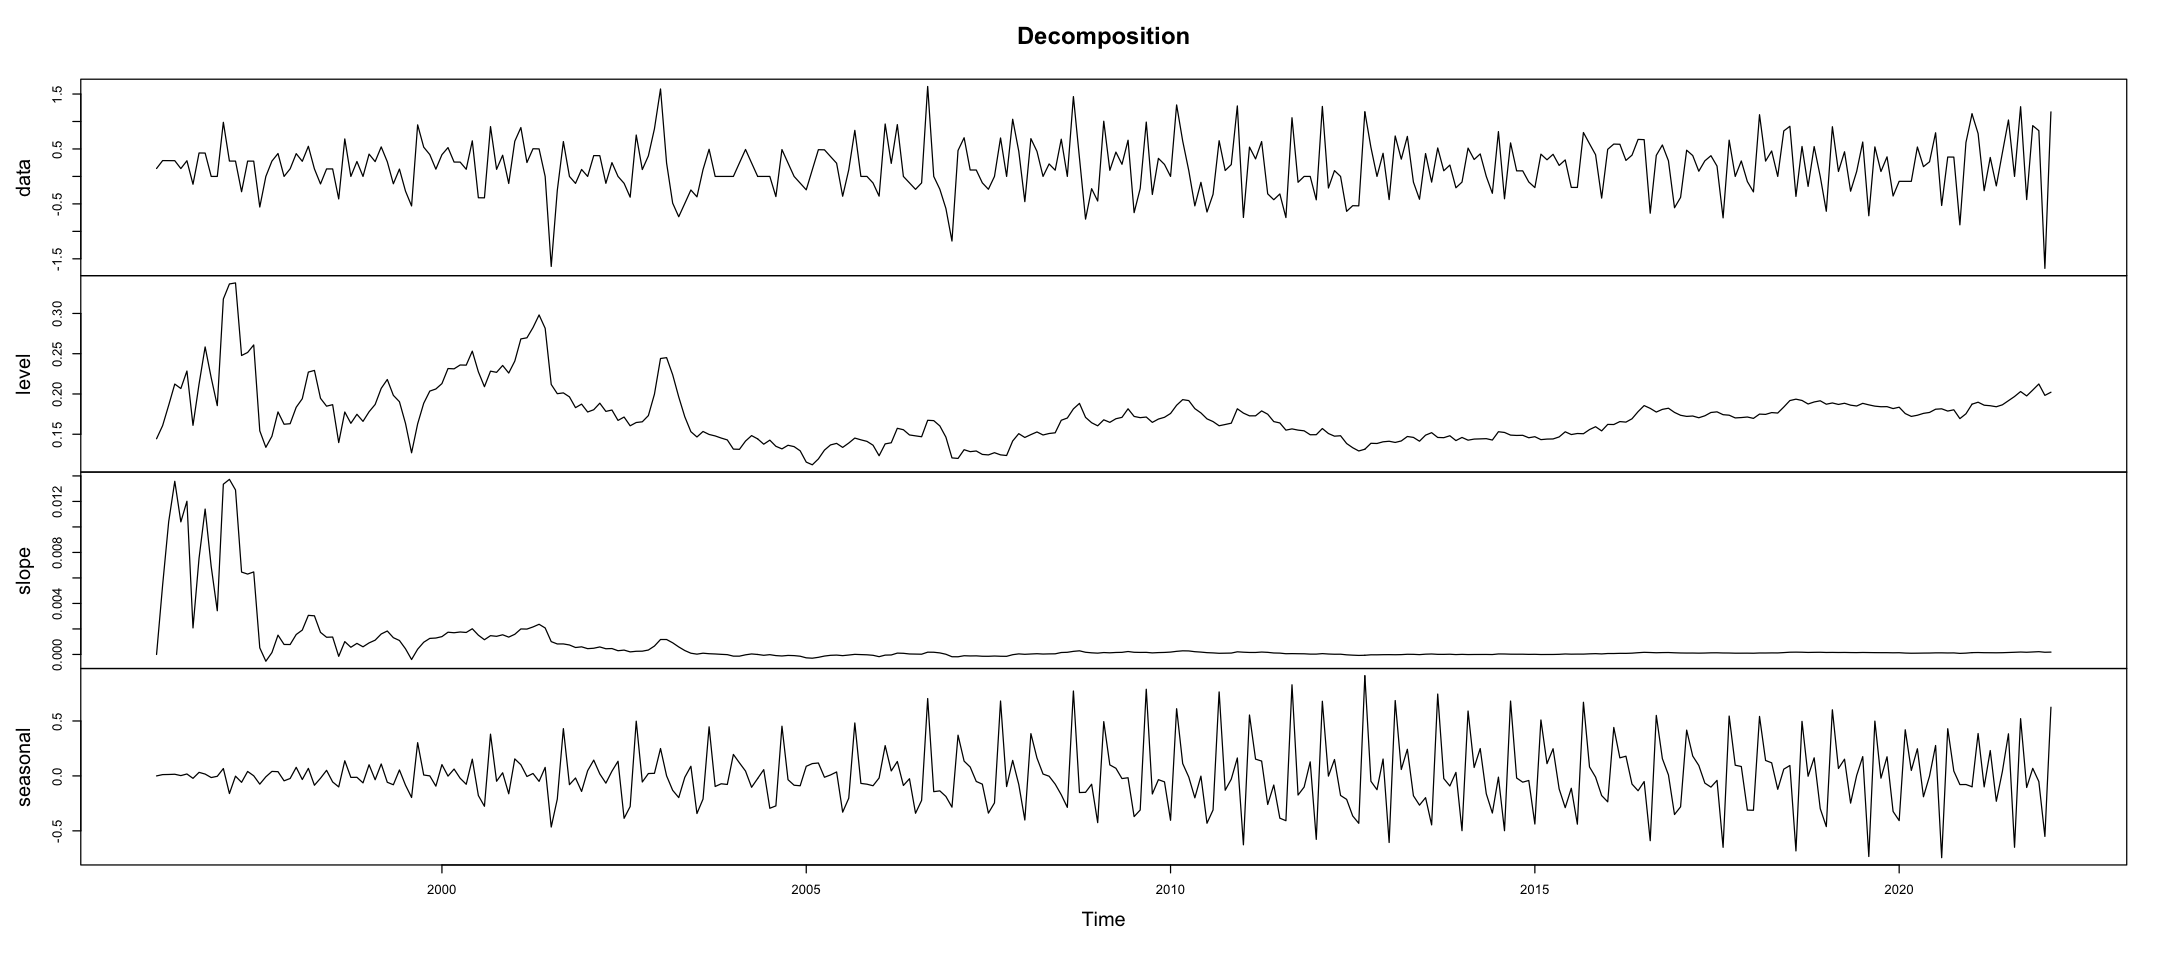

In [166]:
bs_model_decomp <- cbind(i_mom,fitted(bs_model))
colnames(bs_model_decomp) <- c("data","level","slope", "seasonal")
plot(bs_model_decomp, main="Decomposition")

The decomposition of inflation based on the basic structural model indicates the presence of seasonality. Now, I will test the residuals.


	Shapiro-Wilk normality test

data:  bs_model$residuals
W = 0.97294, p-value = 1.283e-05



	Box-Ljung test

data:  bs_model$residuals
X-squared = 16.136, df = 10, p-value = 0.0958


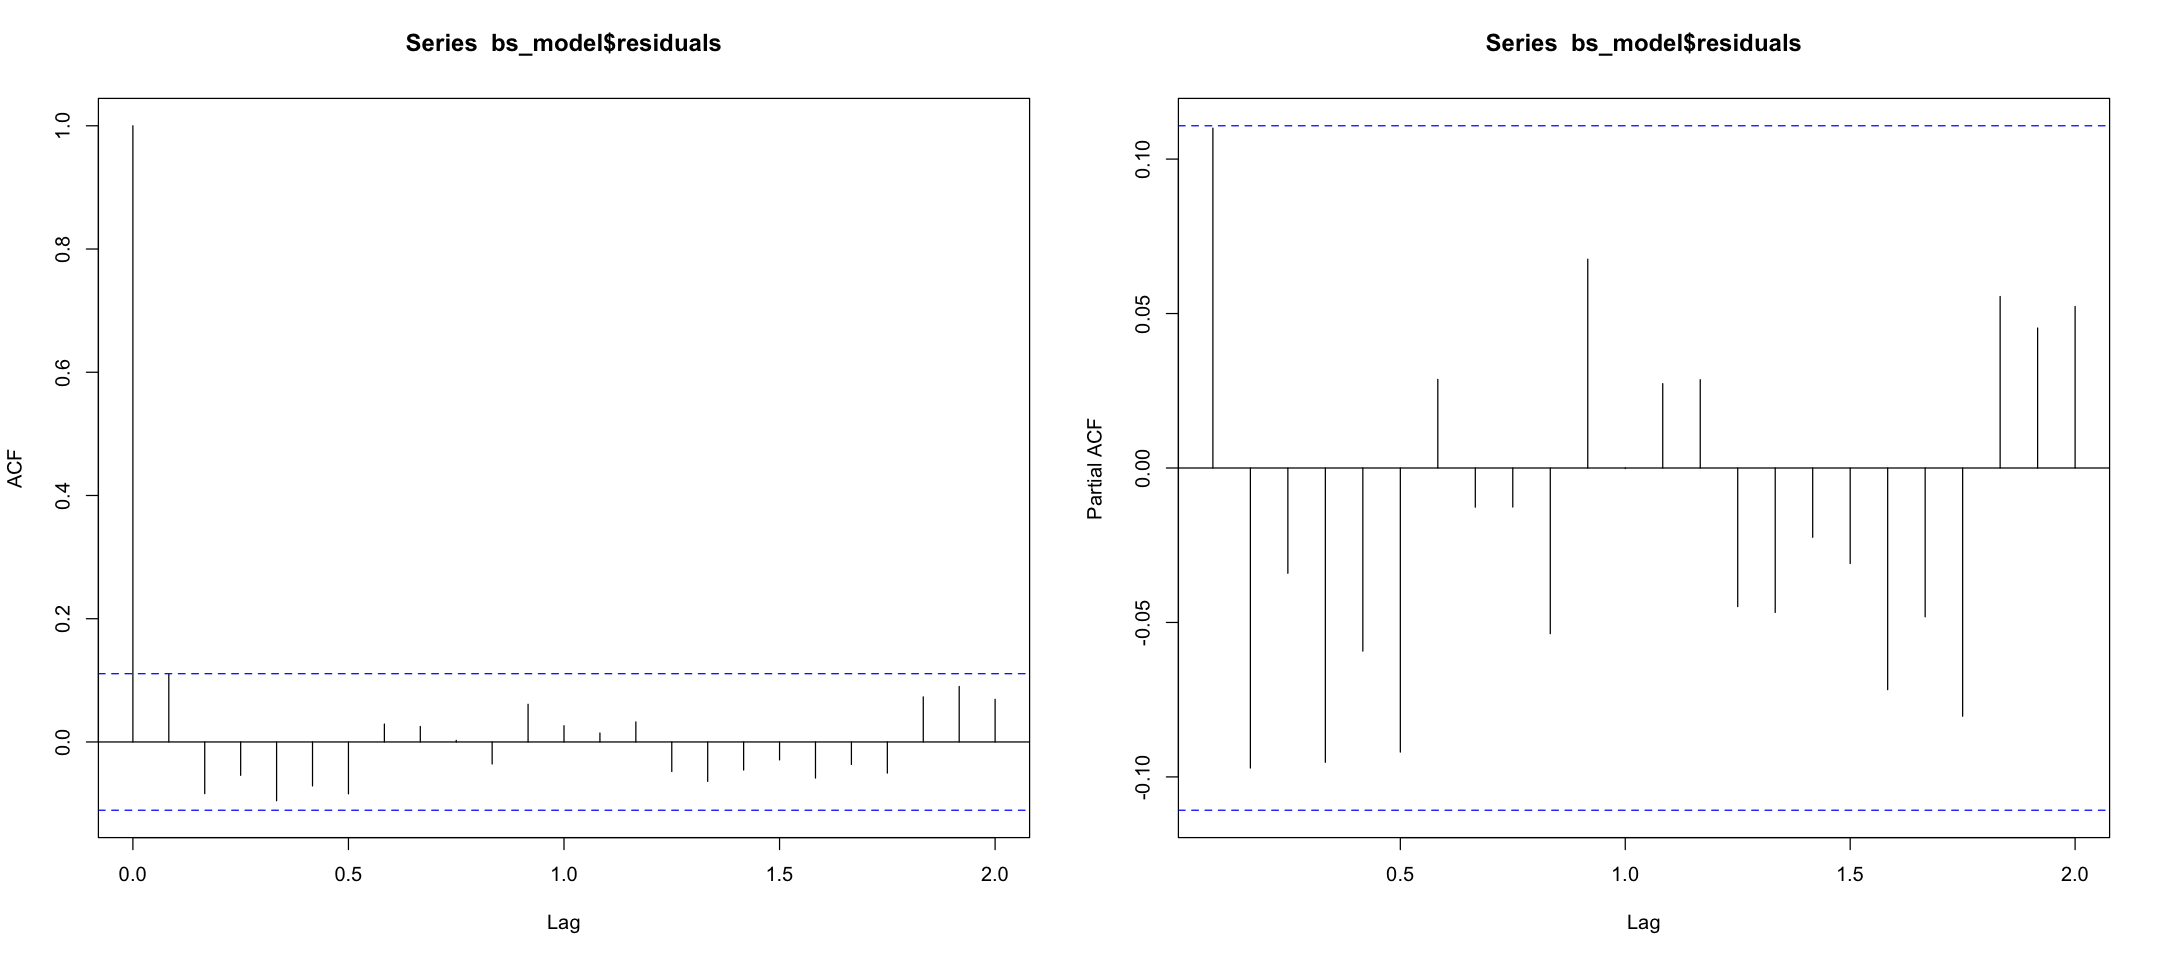

In [322]:
# diagnostics
par(mfrow = c(1, 2))
acf(bs_model$residuals)
pacf(bs_model$residuals)
shapiro.test(bs_model$residuals)
Box.test(bs_model$residuals, lag = 12, type = "Ljung", fitdf = 2)

The residuals look much better than in the previous case. All appears to be satisfactory, as there is no unexplained autocorrelation when the p-value of Ljung-box test of joinf autocorrelation is less than 5% and the Shapiro test would suggest that the residuals are normally distributed when the p-value is less than 5%. In addition, ACF and PACF plots indicates the same.

Jan       Feb       Mar       Apr       May       Jun       Jul      
2022                     0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2023 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2024 0.1756093 0.1756093                                                  
     Aug       Sep       Oct       Nov       Dec      
2022 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2023 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2024

80%        95% 
-0.4511846 -0.7829893

80%       95% 
0.8024033 1.1342080

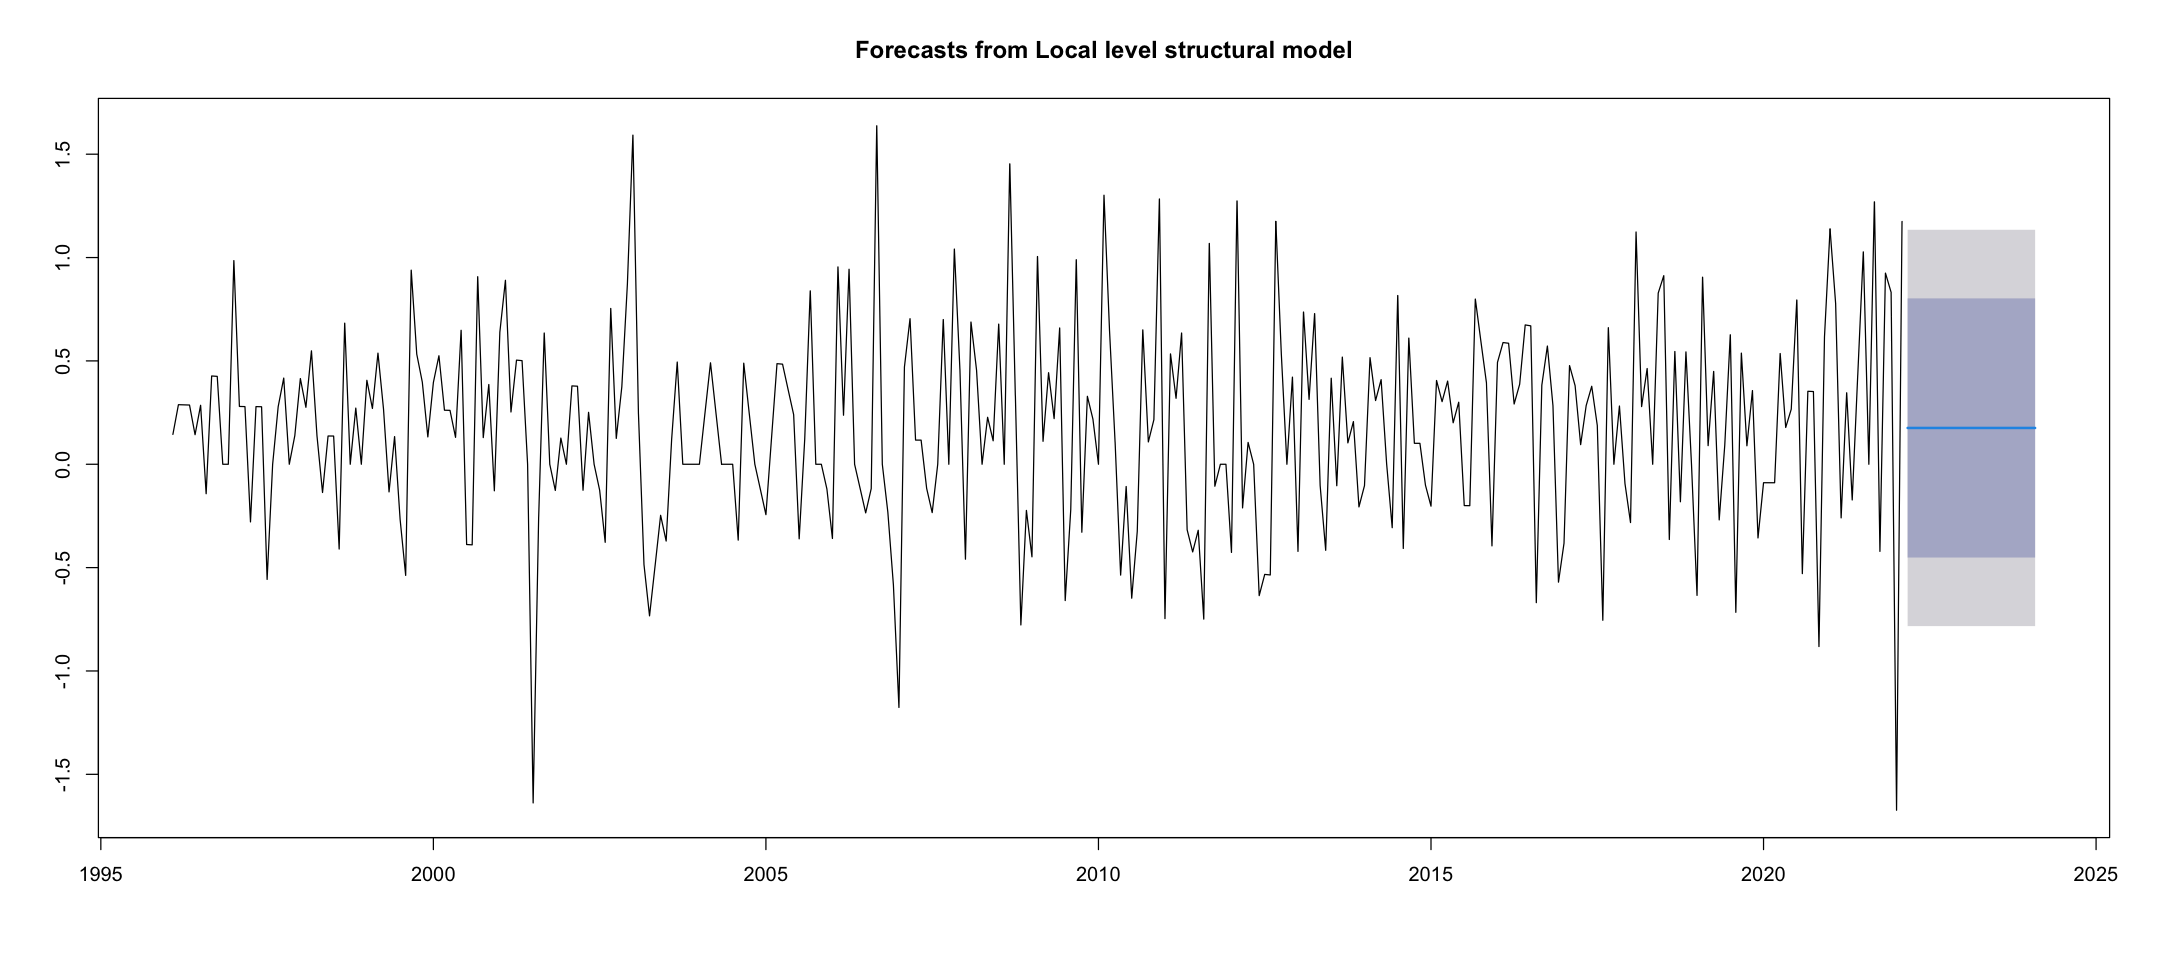

In [173]:
ll_model_f <- forecast(ll_model)
ll_model_f$mean # mean prediction
ll_model_f$lower[1,1:2] # lower confidence interval boundary in the next period
ll_model_f$upper[1,1:2] # upper confidence interval boundary in the next period
plot(ll_model_f)

The local level model predicts that Turkish economy will constantly experience m-o-m changes in inflation about 0.18%. The confidence intervals values are constant over time. They say that we are 95% confident that m-o-m changes will move in range between -0.8% and 1.1%. 

Jan         Feb         Mar         Apr         May         Jun        
2022                          0.08202294  0.43012570 -0.06172141  0.19179447
2023 -0.37526486  0.82955288  0.08423103  0.43233378 -0.05951333  0.19400255
2024 -0.37305678  0.83176097                                                
     Jul         Aug         Sep         Oct         Nov         Dec        
2022  0.53909627 -0.48636569  0.75303998  0.04120382  0.24194446  0.25511503
2023  0.54130436 -0.48415760  0.75524806  0.04341191  0.24415255  0.25732312
2024

80%        95% 
-0.4607668 -0.7481023

80%       95% 
0.6248126 0.9121482

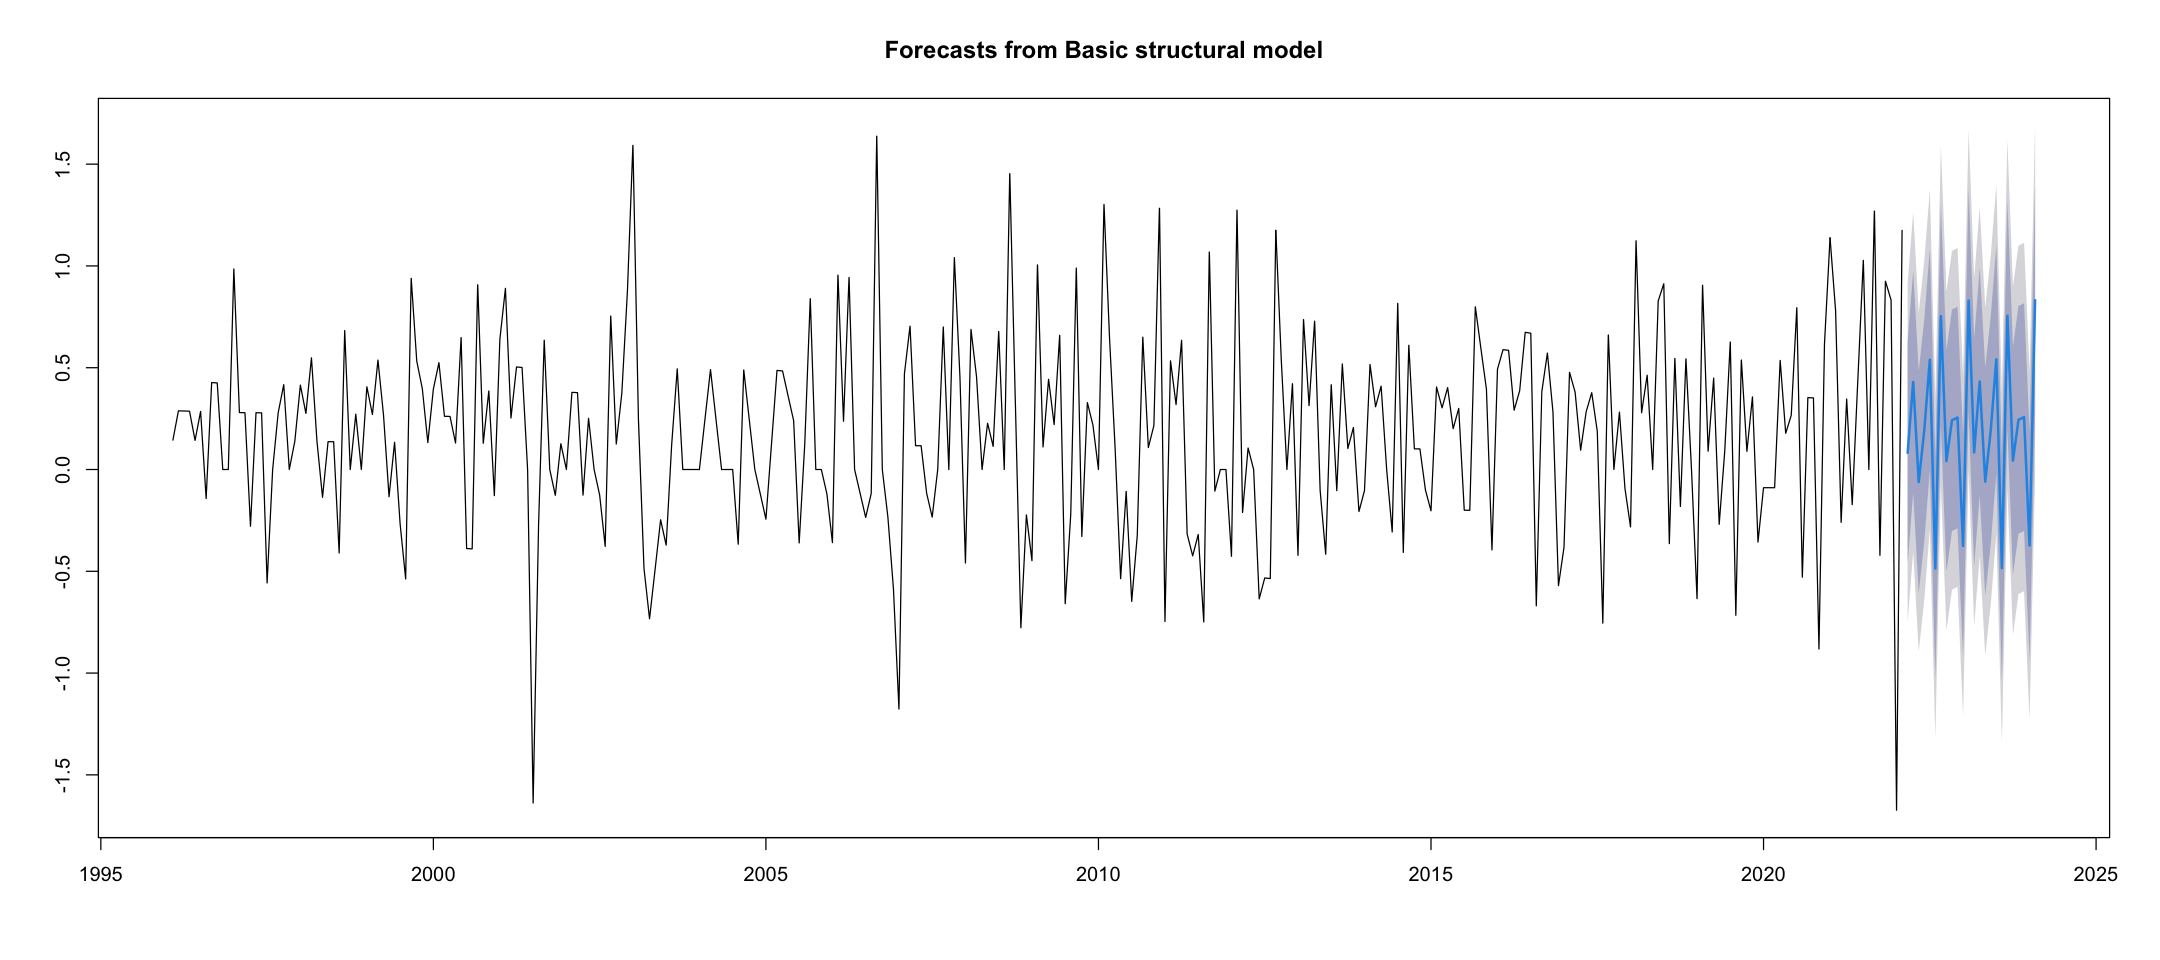

In [168]:
bs_model_f <- forecast(bs_model)
bs_model_f$mean # mean prediction
bs_model_f$lower[1,1:2] # lower confidence interval boundary in the next period
bs_model_f$upper[1,1:2] # upper confidence interval boundary in the next period
plot(bs_model_f)

The implementation of seasonal component into the model cause time-varying prediction. In the next month, we expect 0.08% change compared to February value: It will probably range between -0.7% and 0.9% with 95% confidence.

**2. Redo the exercise with the help of the DLM package or with a Kalman filter code written from scratch. Is the result identical to the previous exercise?**

Firstly, I will build the local level model. Therefore, I specify the polynomial of the first order. I set parameters for the errors in measurement and state equation. Then, I set initial values for the parameters. All of them equal zero.

In [192]:
# model specification
dlm_llm <- function(parm) {
    dlmModPoly(order = 1, dV = exp(parm[1]), dW = exp(parm[2]))
}
#initialization
dlm_llm_fit <- dlmMLE(i_mom, parm = c(0,0), build = dlm_ll_model, hessian = TRUE)
(conv <- dlm_ll_model_fit$convergence)

[1] 0

Now, I construct the likelihood function and generate statistics for the information criteria and the variance-covariance matrix.

In [193]:
loglik <- dlmLL(i_mom, dlmModPoly(1))
n.coef <- 2
r.aic <- (2 * (loglik)) + 2 * (sum(n.coef))  #akaike
r.bic <- (2 * (loglik)) + (log(length(i_mom))) * (n.coef) #bayesian
# t-statistics
dlm_ll_mod <- dlm_ll_model(dlm_llm_fit$par)
obs.error.var <- V(dlm_ll_mod)
state.error.var <- W(dlm_ll_mod)

I need to obtain Kalman filter and smoother. Then, I derive measurements errors from the Kalman filter's residuals. Moreover, I can get stochastic trend from the model. Additionaly, I conduct diagnostic tests.


	Shapiro-Wilk normality test

data:  resids
W = 0.98929, p-value = 0.02122



	Box-Ljung test

data:  resids
X-squared = 86.312, df = 10, p-value = 2.875e-14


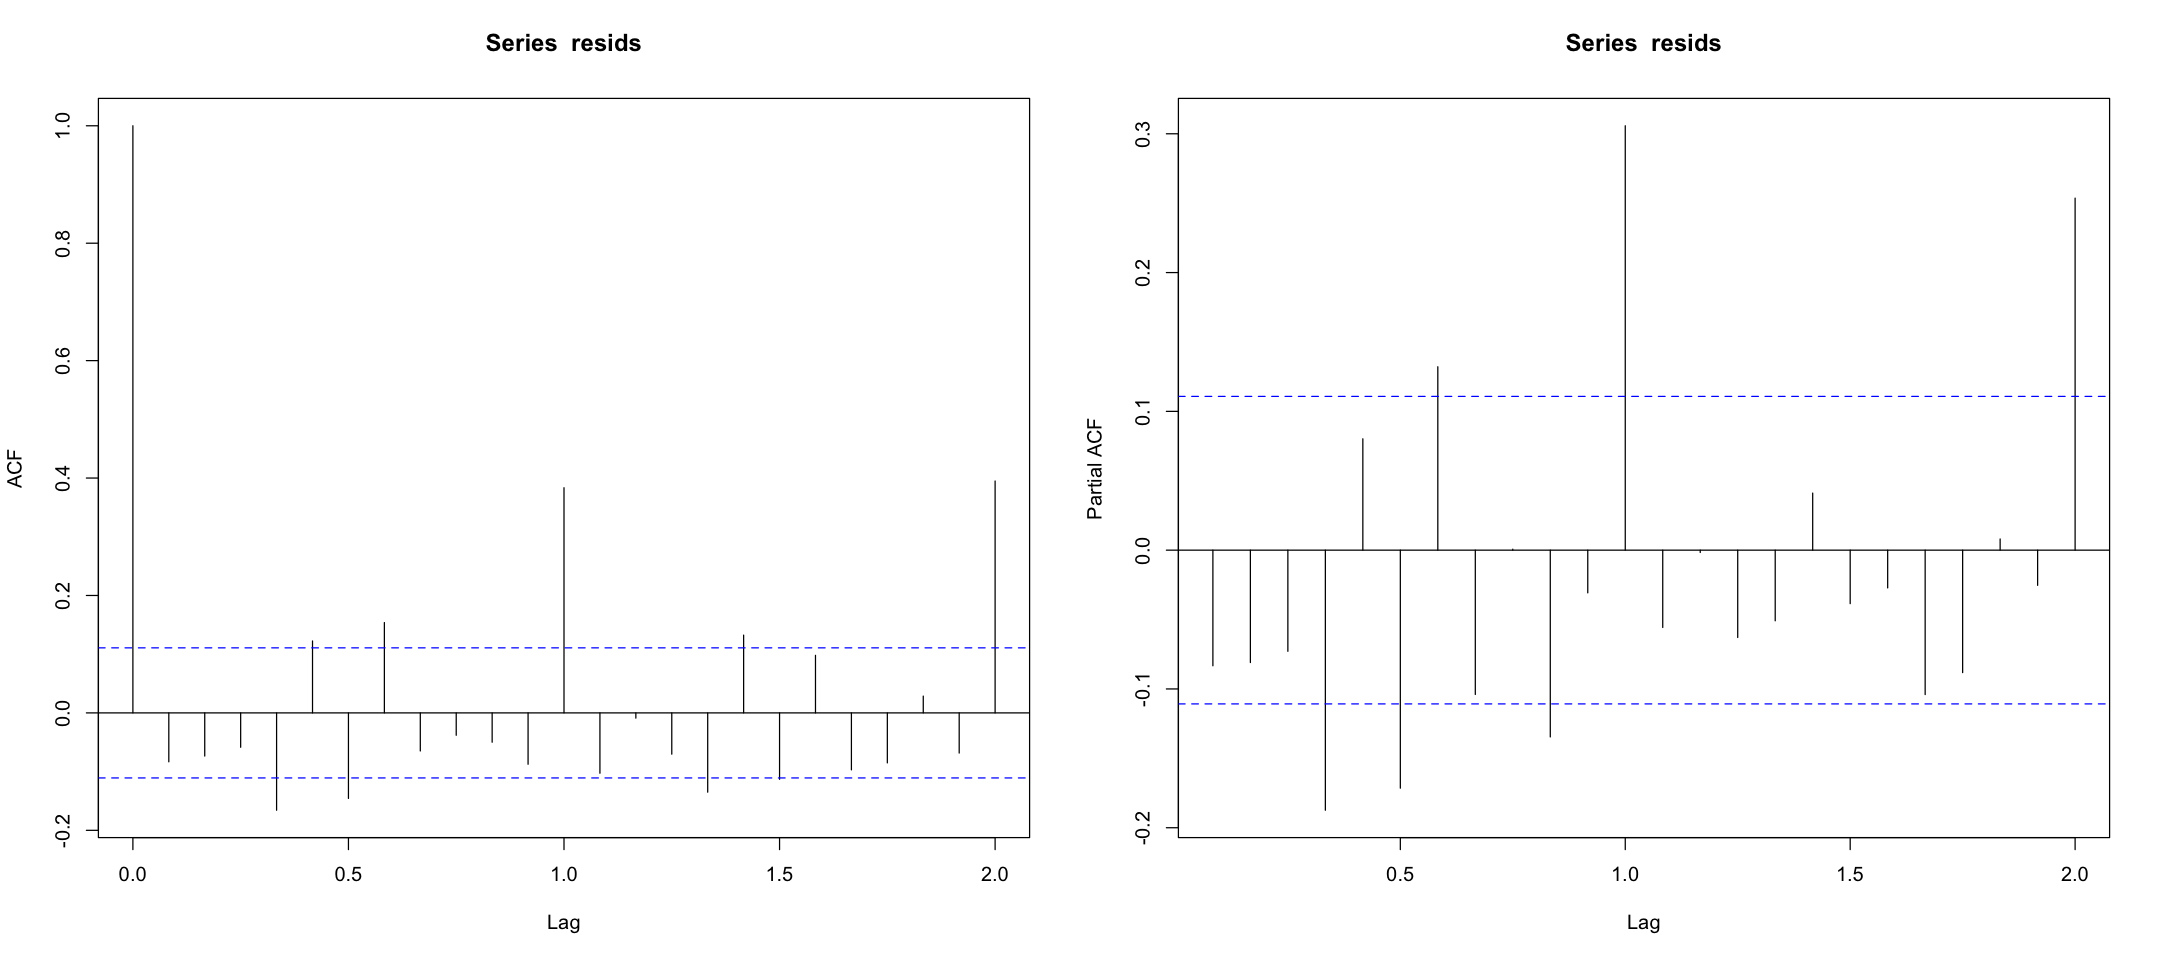

In [320]:
dlm_ll_filtered <- dlmFilter(i_mom, mod = dlm_ll_mod) # Kalman filter
dlm_ll_smoothed <- dlmSmooth(dlm_ll_filtered) #Kalman smoother

resids <- residuals(dlm_ll_filtered, sd = FALSE) #measurement errors

# stochastic trend
mu <- dropFirst(dlm_ll_smoothed$s)
mu.1 <- mu[1]
mu.end <- mu[length(mu)]

# diagnostics
par(mfrow = c(1, 2))
acf(resids)
pacf(resids)
shapiro.test(resids)
Box.test(resids, lag = 12, type = "Ljung", fitdf = 2)

Diagnostic tests on residuals provides the same outcome as in the case of model building by StructTS function. Although Ljung-Box and Shapiro-Wilk tests show there is no significant evidence for unexplained autocorrelation, the ACF and PACF plots tell little bit different story.

Now, I plot the fitted and smoothed values. For this purpose, I create confidence intervals for the smoothed line.

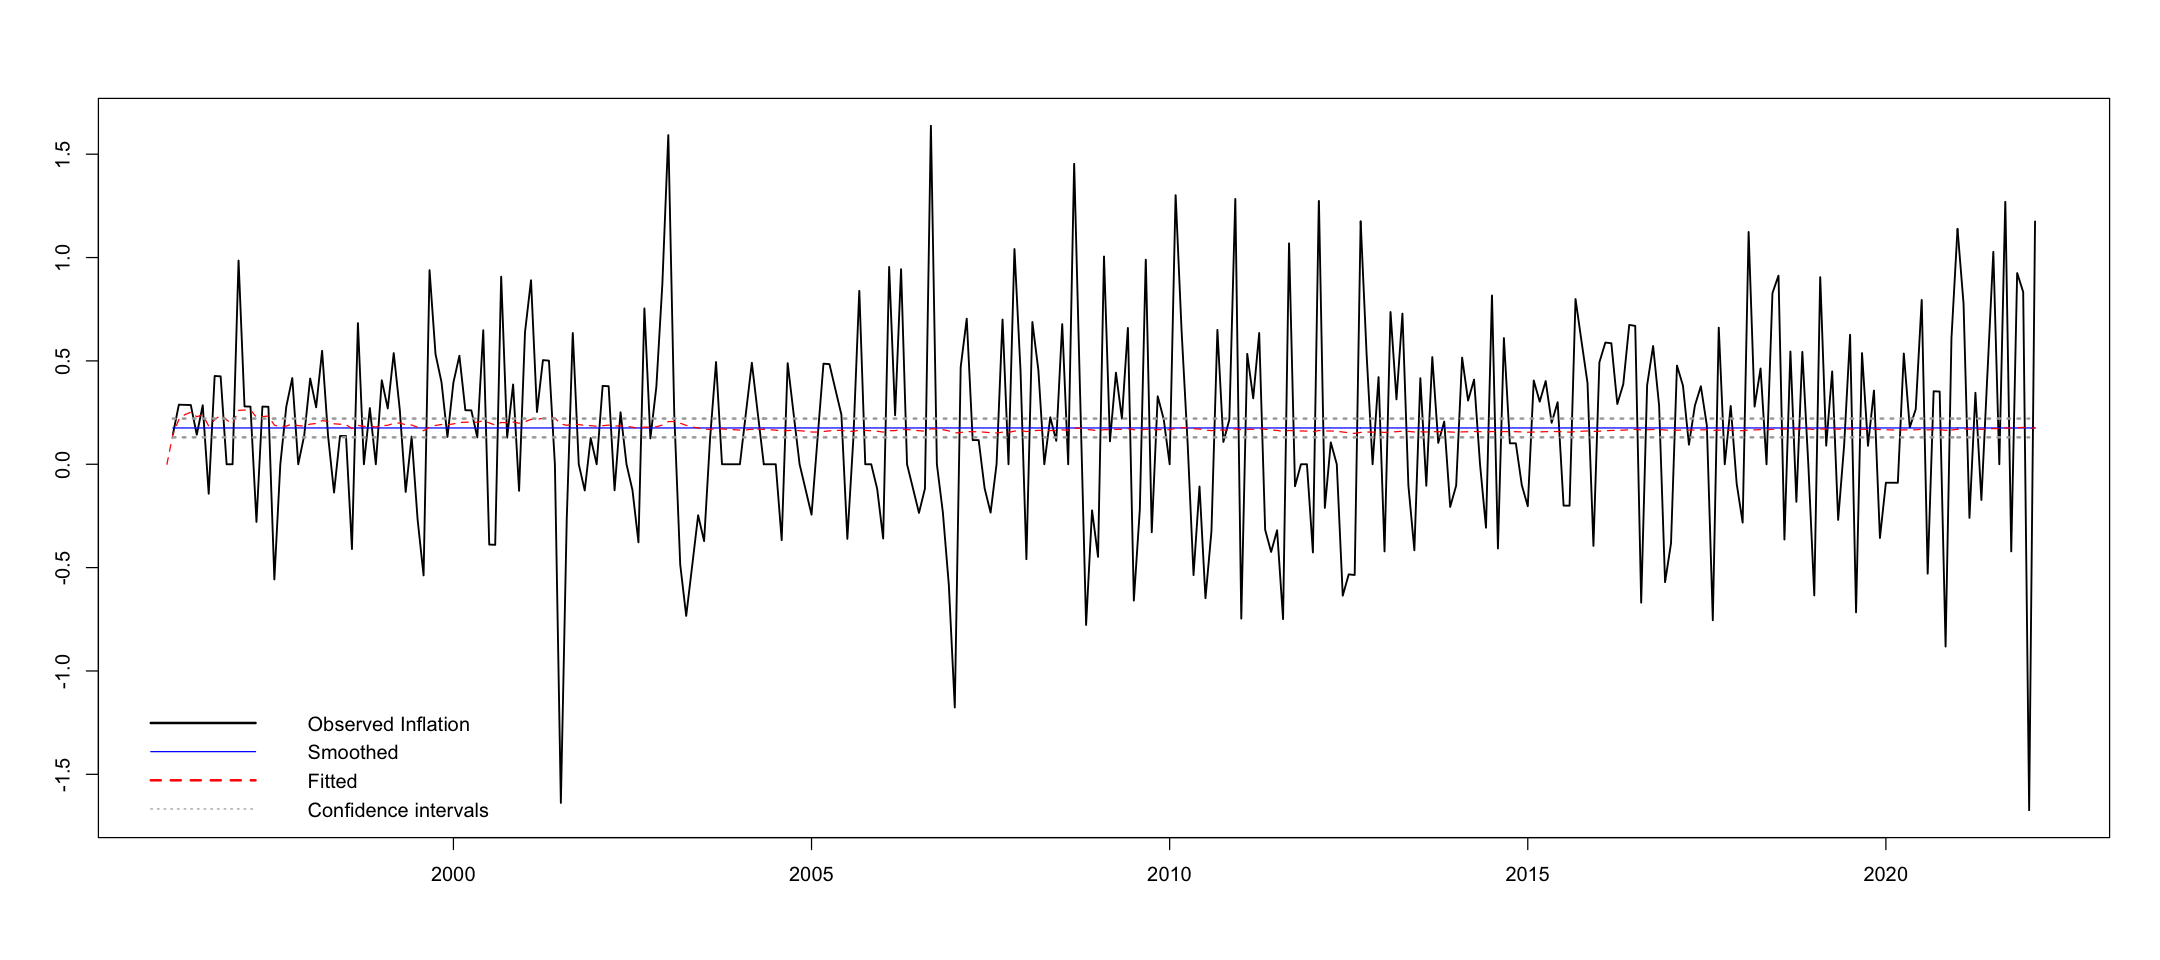

In [223]:
# confidence intervals
conf.tmp <- unlist(dlmSvd2var(dlm_ll_smoothed$U.S, dlm_ll_smoothed$D.S))
conf <- ts(as.numeric(conf.tmp)[-1], start = c(1996, 1), 
           frequency = 12)
wid <- qnorm(0.05, lower = FALSE) * sqrt(conf)
conf.pos <- mu + wid
conf.neg <- mu - wid

# Plot
plot.ts(i_mom, col = "black", xlab = "", ylab = "", lwd = 1.5)
lines(mu, col = "blue") # smoothed
lines(dlm_ll_filtered$m, col = "red", lty = "dashed") #fitted
lines(conf.pos, col = "darkgrey", lty = "dotted", lwd = 2) # conf. interval
lines(conf.neg, col = "darkgrey", lty = "dotted", lwd = 2) # conf. interval
legend("bottomleft", legend = c("Observed Inflation", "Smoothed","Fitted", "Confidence intervals"), 
    lwd = c(2, 1), col = c("black", "blue", "red", "darkgrey"), bty = "n", lty = c("solid", "solid", "dashed", "dotted"))

The plot is identical to the plot produced by StructTS function.

Jan       Feb       Mar       Apr       May       Jun       Jul      
2022                     0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2023 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2024 0.1756093 0.1756093                                                  
     Aug       Sep       Oct       Nov       Dec      
2022 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2023 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2024

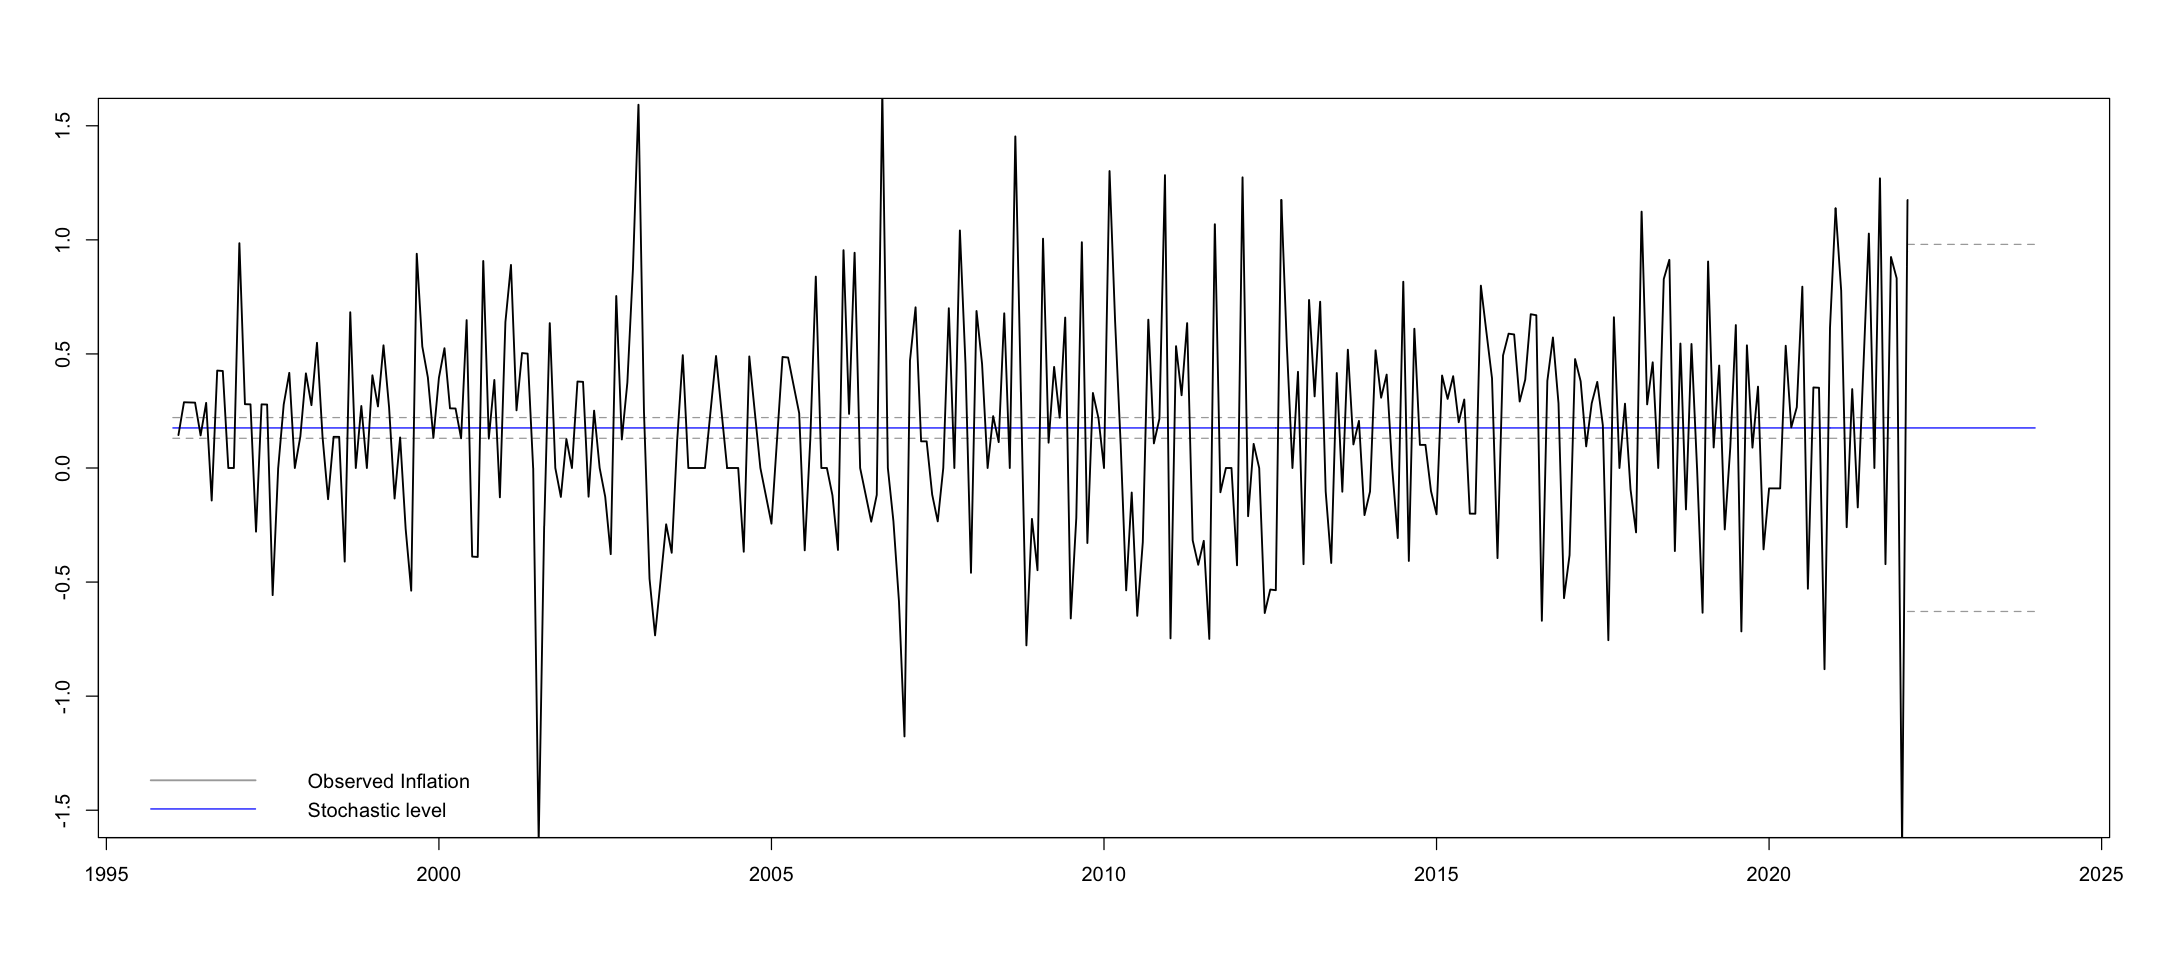

In [319]:
dlm_ll_f <- dlmForecast(dlm_ll_filtered, nAhead = 24)
var.2 <- unlist(dlm_ll_f$Q)
wid.2 <- qnorm(0.05, lower = FALSE) * sqrt(var.2)
comb.fore <- cbind(dlm_ll_f$f, dlm_ll_f$f + wid.2, dlm_ll_f$f - wid.2)
comb.state <- cbind(mu, conf.pos, conf.neg)
result <- ts(rbind(comb.state, comb.fore), start = c(1996,1), frequency = 12)

plot.ts(result, col = c("blue", "darkgrey", "darkgrey"), plot.type = "single", 
        xlab = "", ylab = "", lty = c(1, 2, 2), ylim = c(-1.5, 1.5))
lines(i_mom, col = "black", lwd = 1.5)
legend("bottomleft", legend = c("Observed Inflation", "Stochastic level"), 
       lwd = c(1.5, 1), col = c("darkgrey", "blue"), bty = "n")
dlm_ll_f$f # mean forecast

For the local level model, dlm package provides the same mean forecast as the StructTS function. Now, I will construct basic structural model with level, slope and seasonality. I will analogous procedure to the first model created by functions from dlm package.

In [329]:
dlm_bsm <- function(parm) {
    mod <- dlmModPoly(order = 2, dV = exp(parm[1]), dW = exp(parm[2:3])) + dlmModSeas(frequency = 12)
    V(mod) <- exp(parm[1])
    diag(W(mod))[1:3] <- exp(parm[2:4])
    return(mod)
}

In [330]:
dlm_bsm_fit <- dlmMLE(i_mom, rep(0, 4), build = dlm_bsm, hessian = TRUE)
(conv <- dlm_bsm_fit$convergence)  # zero for converged

# information criteria
loglik <- dlmLL(i_mom, dlmModPoly(2) + dlmModSeas(12)) # polynomial of the second order + seasonality
n.coef <- 4
r.aic <- (2 * (loglik)) + 2 * (sum(n.coef))  
r.bic <- (2 * (loglik)) + (log(length(i_mom))) * (n.coef)

# t-statistics
dlm_bsm_mod <- dlm_bsm(dlm_bsm_fit$par)
obs.error.var <- V(dlm_bsm_mod)
state.error.var <- diag(W(dlm_bsm_mod))

[1] 0

In [313]:
dlm_bsm_filtered <- dlmFilter(i_mom, mod = dlm_bsm_mod)
dlm_bsm_smoothed <- dlmSmooth(dlm_bsm_filtered)
dlm_bsm_resids <- residuals(dlm_bsm_filtered, sd = FALSE)
dlm_bsm_mu <- dropFirst(dlm_bsm_smoothed$s[, 1])

# slope
dlm_bsm_upsilon <- dropFirst(dlm_bsm_smoothed$s[, 2])
dlm_bsm_ups.1 <- dlm_bsm_upsilon[1]
dlm_bsm_ups.end <- dlm_bsm_upsilon[length(dlm_bsm_mu)]

# seasonality
dlm_bsm_gammas <- dropFirst(dlm_bsm_smoothed$s[, 3])
dlm_bsm_mu.1 <- dlm_bsm_mu[1]
dlm_bsm_mu.end <- dlm_bsm_mu[length(dlm_bsm_mu)]
dlm_bsm_gammas.1 <- dlm_bsm_gammas[1]
dlm_bsm_gammas.end <- dlm_bsm_gammas[length(dlm_bsm_mu)]


	Shapiro-Wilk normality test

data:  dlm_bsm_resids
W = 0.97134, p-value = 6.997e-06



	Box-Ljung test

data:  dlm_bsm_resids
X-squared = 11.861, df = 10, p-value = 0.2945


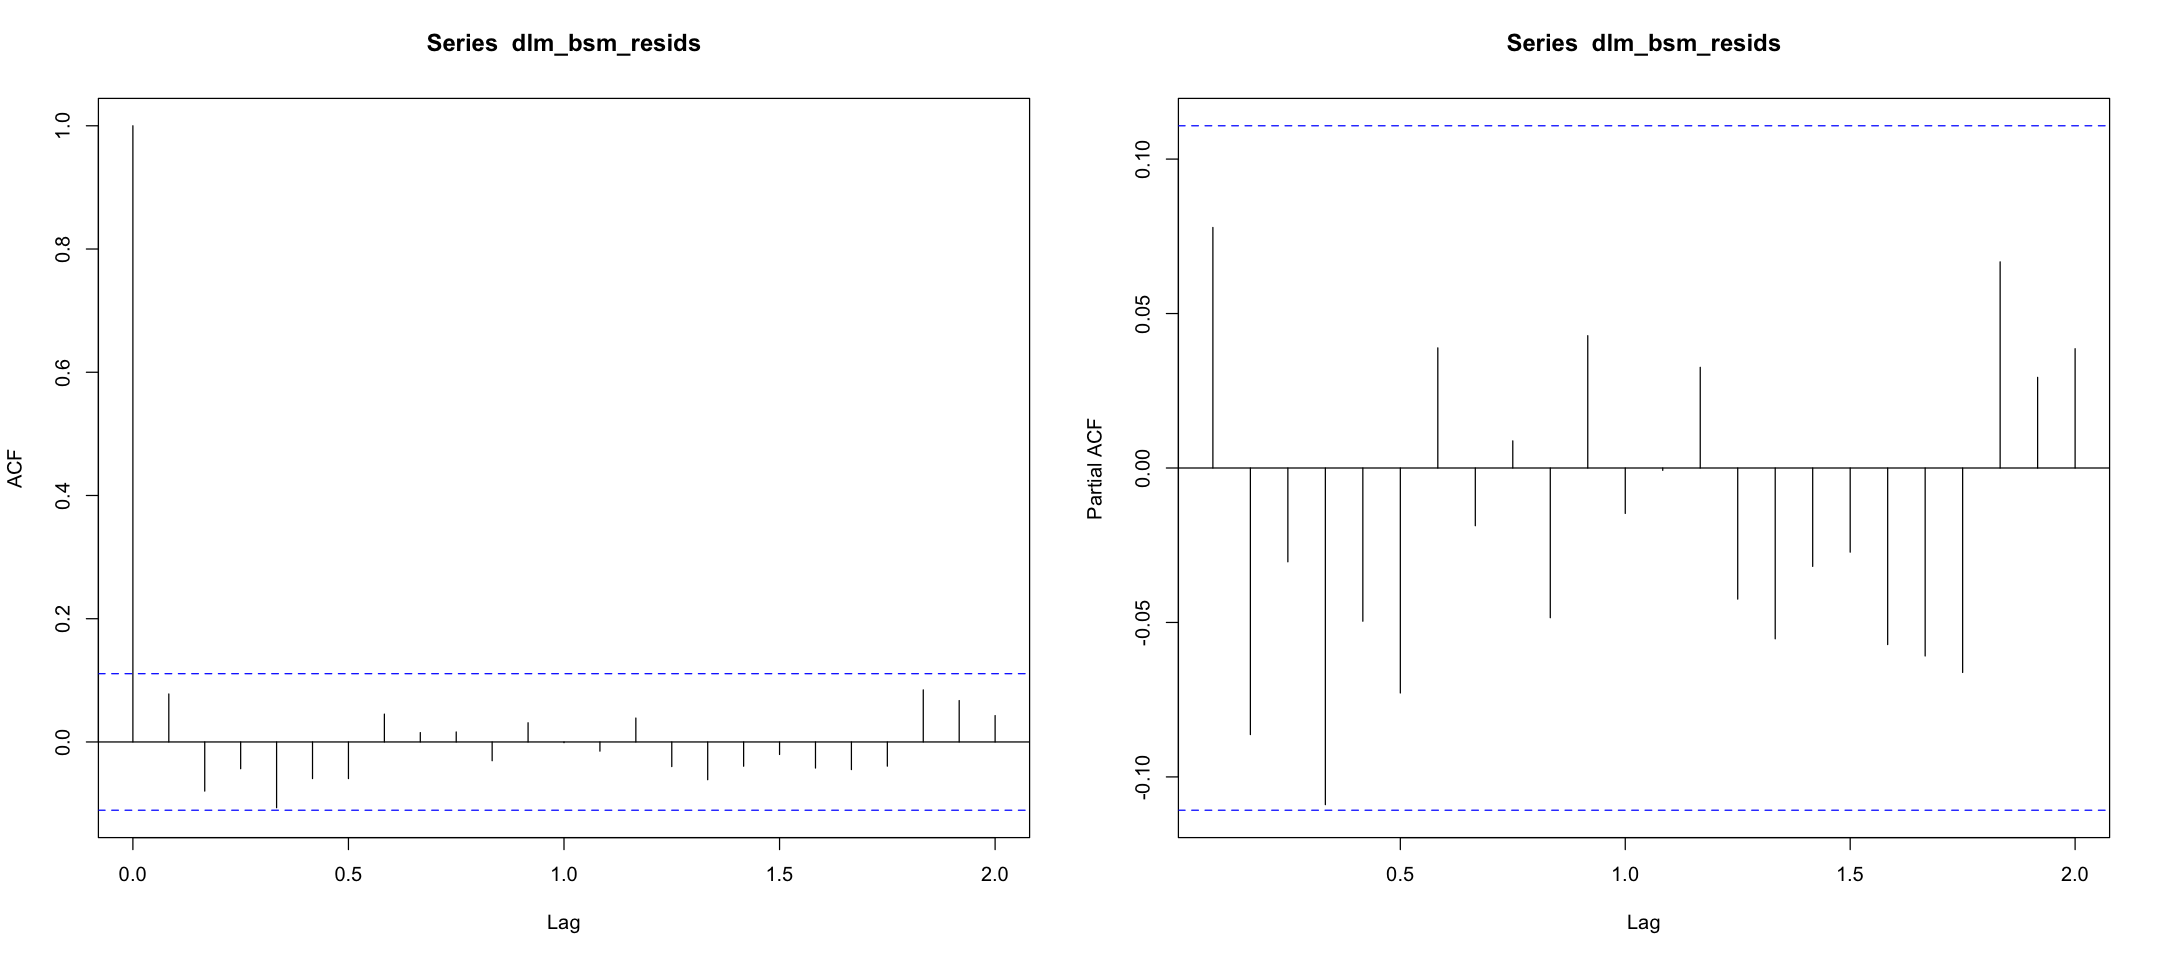

In [323]:
# diagnostics
par(mfrow = c(1, 2))
acf(dlm_bsm_resids)
pacf(dlm_bsm_resids)
shapiro.test(dlm_bsm_resids)
Box.test(dlm_bsm_resids, lag = 12, type = "Ljung", fitdf = 2)

The Shapiro-Wilk normality test together with ACF and PACF plots look satisfactory, but Llung-Box test on joint autocorellation suggests there is still some unexplained autocorrelation. This results differs from the outcome of StructTS function. It may be caused by wrong specification of the model. Unfortunately, I did not find the mistake in my code.

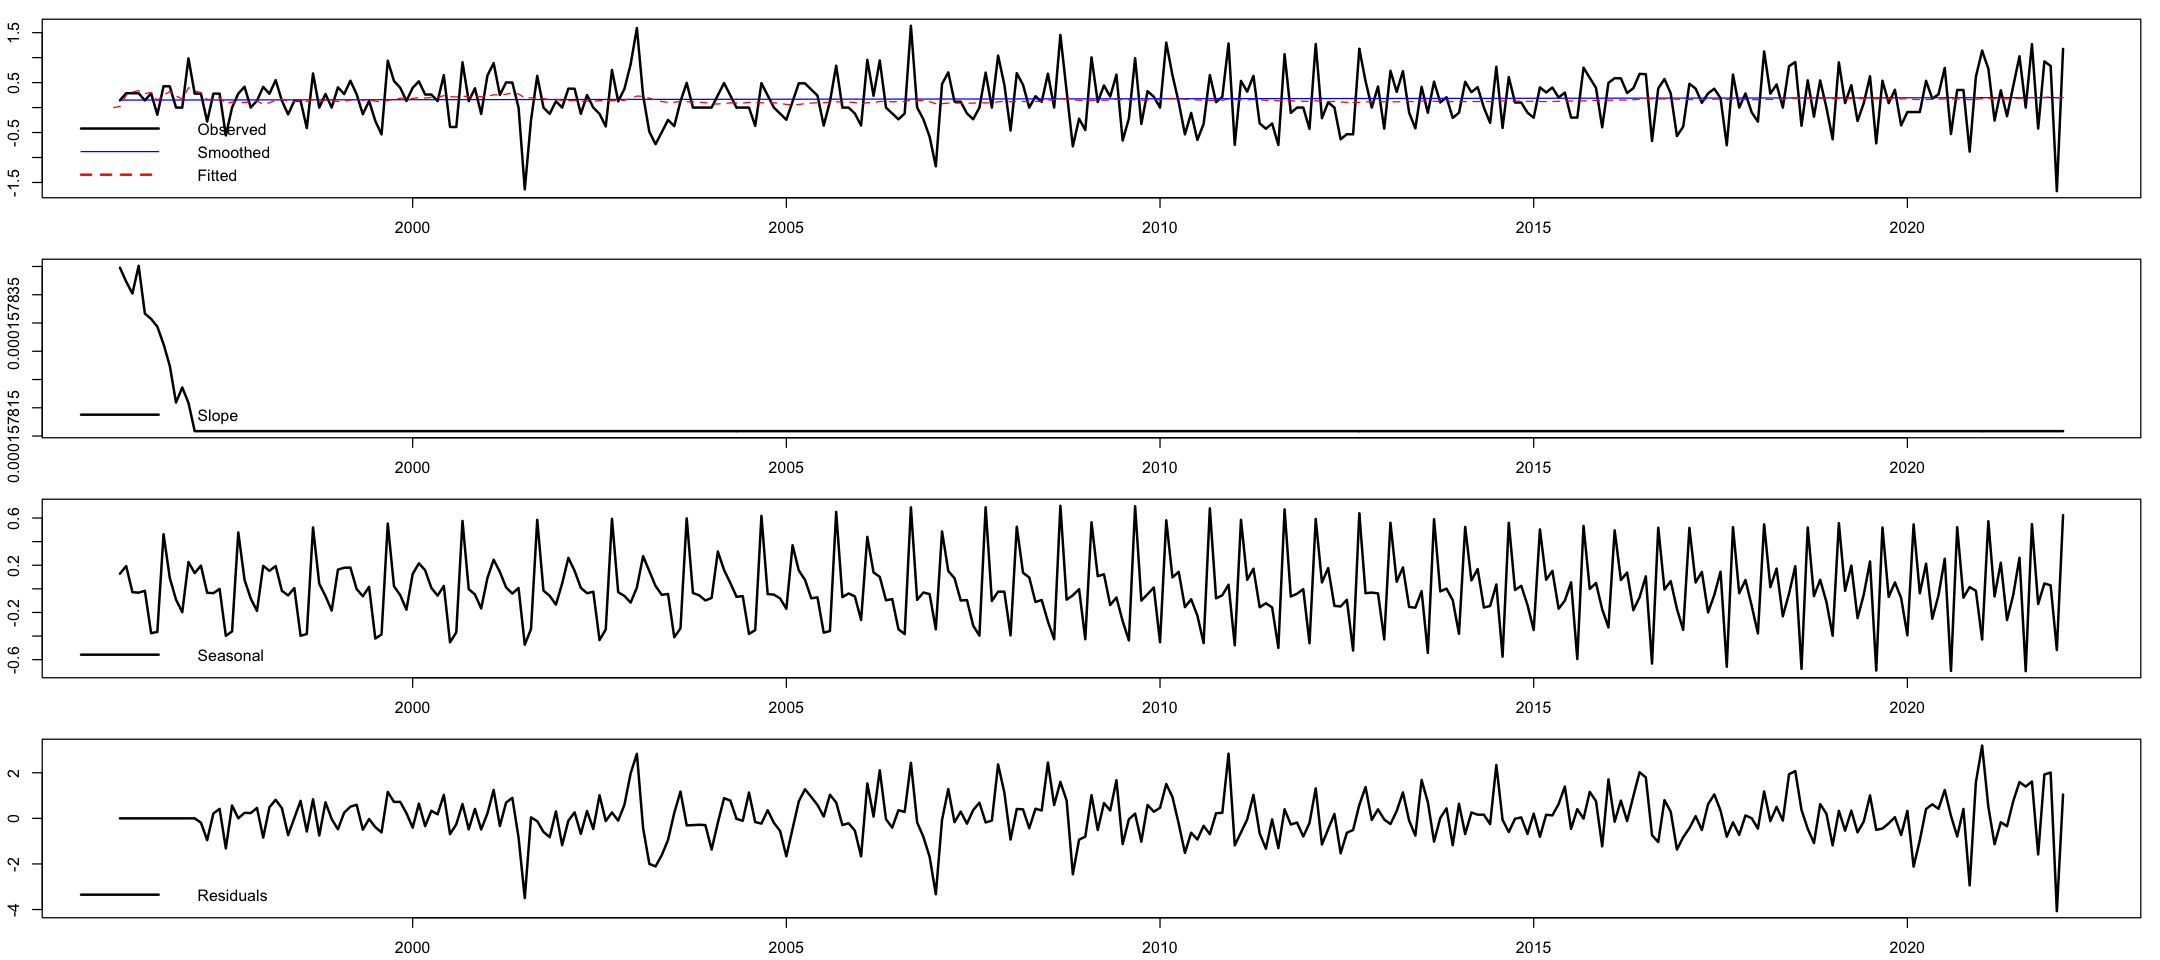

In [317]:
par(mfrow = c(4, 1), mar = c(2.2, 2.2, 1, 1), cex = 0.8)
plot.ts(i_mom, col = "black", xlab = "", ylab = "", lwd = 2)
lines(dlm_bsm_mu, col = "blue")
lines(dlm_bsm_filtered$m[,1], col = "red", lty = "dashed") #fitted
legend("bottomleft", legend = c("Observed", "Smoothed", "Fitted"), 
    lwd = c(2, 1), col = c("black", "blue", "red"), lty=c("solid", "solid", "dashed"), bty = "n")

plot.ts(dlm_bsm_upsilon, col = "black", xlab = "", ylab = "", 
    lwd = 2)
legend("bottomleft", legend = "Slope", lwd = 2, col = "black", 
    bty = "n")

plot.ts(dlm_bsm_gammas, col = "black", xlab = "", ylab = "", 
    lwd = 2)
legend("bottomleft", legend = "Seasonal", lwd = 2, col = "black", 
    bty = "n")

plot.ts(dlm_bsm_resids, ylab = "", xlab = "", col = "black", 
    lwd = 2)
legend("bottomleft", legend = "Residuals", lwd = 2, col = "black", 
    bty = "n")

Jan         Feb         Mar         Apr         May         Jun        
2022                          0.12709568  0.42090336 -0.06342292  0.14936690
2023 -0.31647735  0.82489761  0.12898947  0.42279715 -0.06152913  0.15126069
2024 -0.31458356  0.82679140                                                
     Jul         Aug         Sep         Oct         Nov         Dec        
2022  0.46386185 -0.49658943  0.74880499  0.07210858  0.24676571  0.23074680
2023  0.46575564 -0.49469564  0.75069878  0.07400237  0.24865950  0.23264059
2024

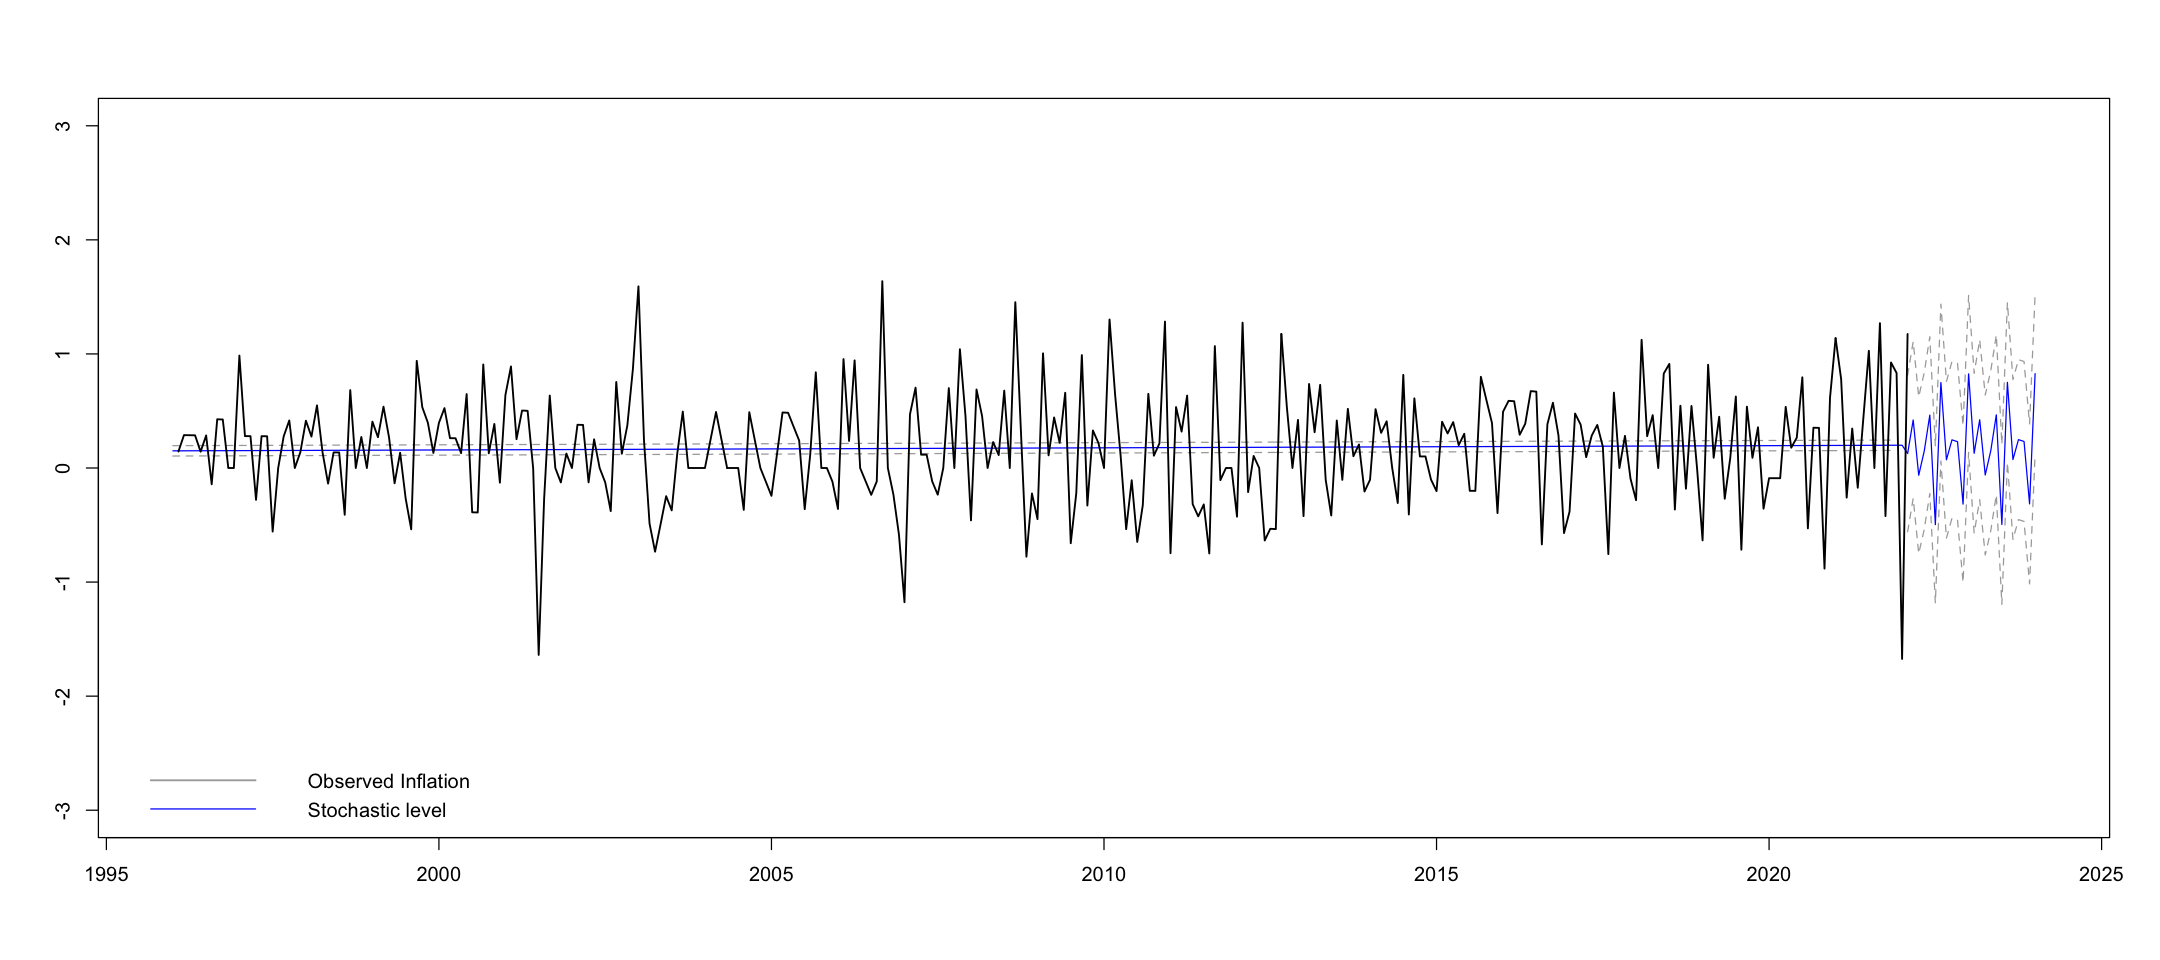

In [324]:
# confidence intervals for smoothed
bsm_conf.pos <- dlm_bsm_mu + wid
bsm_conf.neg <- dlm_bsm_mu - wid

#forecasting
dlm_bsm_f <- dlmForecast(dlm_bsm_filtered, nAhead = 24)
var.2 <- unlist(dlm_bsm_f$Q)
wid.2 <- qnorm(0.05, lower = FALSE) * sqrt(var.2)
comb.fore <- cbind(dlm_bsm_f$f, dlm_bsm_f$f + wid.2, dlm_bsm_f$f - wid.2)
comb.state <- cbind(dlm_bsm_mu, bsm_conf.pos, bsm_conf.neg)
result <- ts(rbind(comb.state, comb.fore), start = c(1996,1), frequency = 12)
 
#plot
plot.ts(result, col = c("blue", "darkgrey", "darkgrey"), plot.type = "single", 
        xlab = "", ylab = "", lty = c(1, 2, 2), ylim = c(-3, 3))
lines(i_mom, col = "black", lwd = 1.5)
legend("bottomleft", legend = c("Observed Inflation", "Stochastic level"), 
       lwd = c(1.5, 1), col = c("darkgrey", "blue"), bty = "n")
dlm_bsm_f$f # mean forecast

In case of basic structural model, I obtain slightly different forecast than by using StructTS function. There are two possible explanations for it. I probably made a mistake by combining a second-order polynomial and seasonality element. This hypothesis is supported by the diagnostics tests. Alternatively, the construction of slope and seasonality terms is diffentt in the StructTS function.

Consequently, I consider Kalman filter model estimated by the StructTS function as the benchmark model for the next task.

**3. Make ARIMA prediction as well, and compare the prediction with the prediction from the Kalman filter model.**

First of all, I test data for stationarity. The Augmented Dickey-Fuller Test indicates that data are stationary. The ACF plot also shows the same. Both ACF and PACF suggest there some distant lags are significant.

Warning message in adf.test(i_mom):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  i_mom
Dickey-Fuller = -7.2179, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


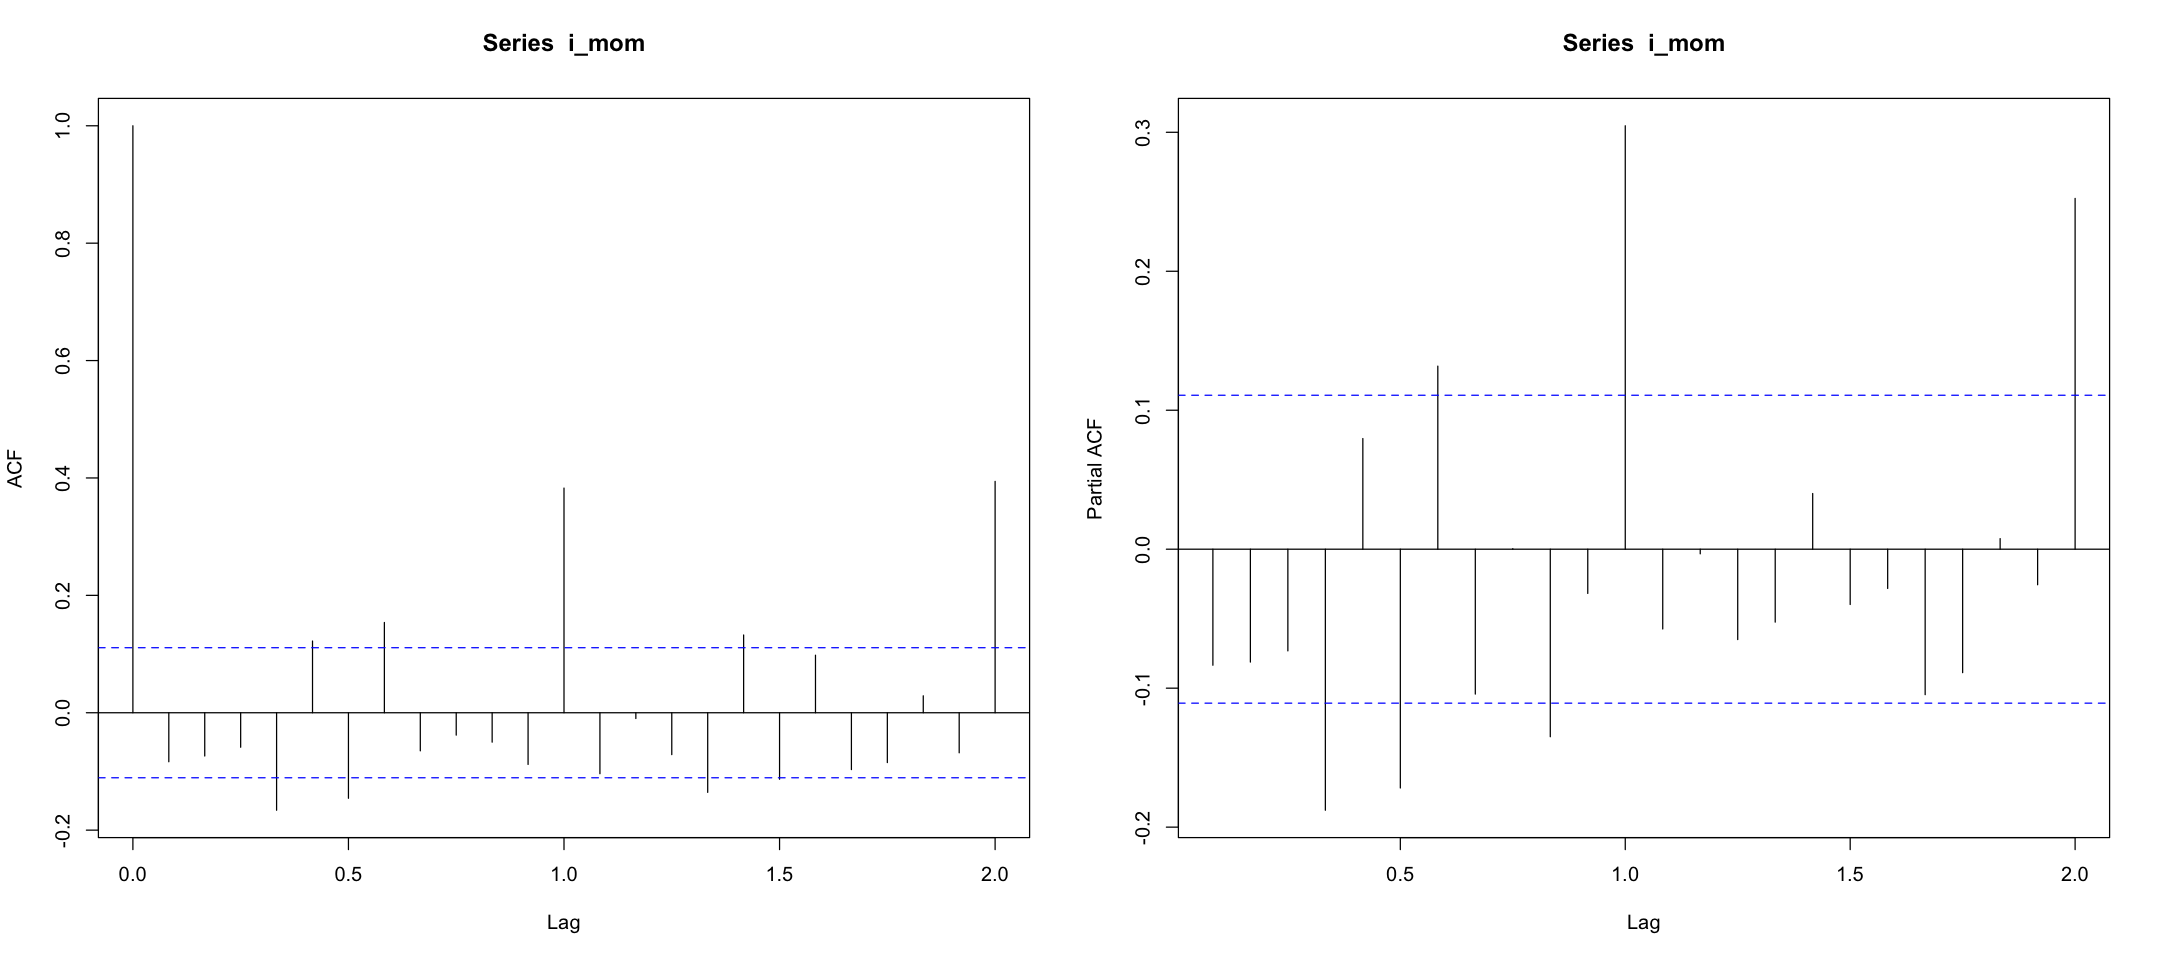

In [169]:
par(mfrow = c(1, 2))
acf(i_mom)
pacf(i_mom)
adf.test(i_mom)

Now, I can estimate the model using auto.arima function in R. I am aware of the fact that auto.arima does not always provide the best fit of the series. They tend to overfit data that resembles white noise process. Therefore, I have chosen Bayesian information criterion as tool for model selection. It is quite stringent in penalization for additional parameters. Additionally, I do not include seasonal parameters to get model that is similar to the local level model. I will include seasonality later.

Series: i_mom 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.1756
s.e.  0.0276

sigma^2 = 0.2384:  log likelihood = -219.27
AIC=442.53   AICc=442.57   BIC=450.03


	Shapiro-Wilk normality test

data:  arima_model$residuals
W = 0.98929, p-value = 0.02119



	Box-Ljung test

data:  arima_model$residuals
X-squared = 86.192, df = 10, p-value = 3.031e-14


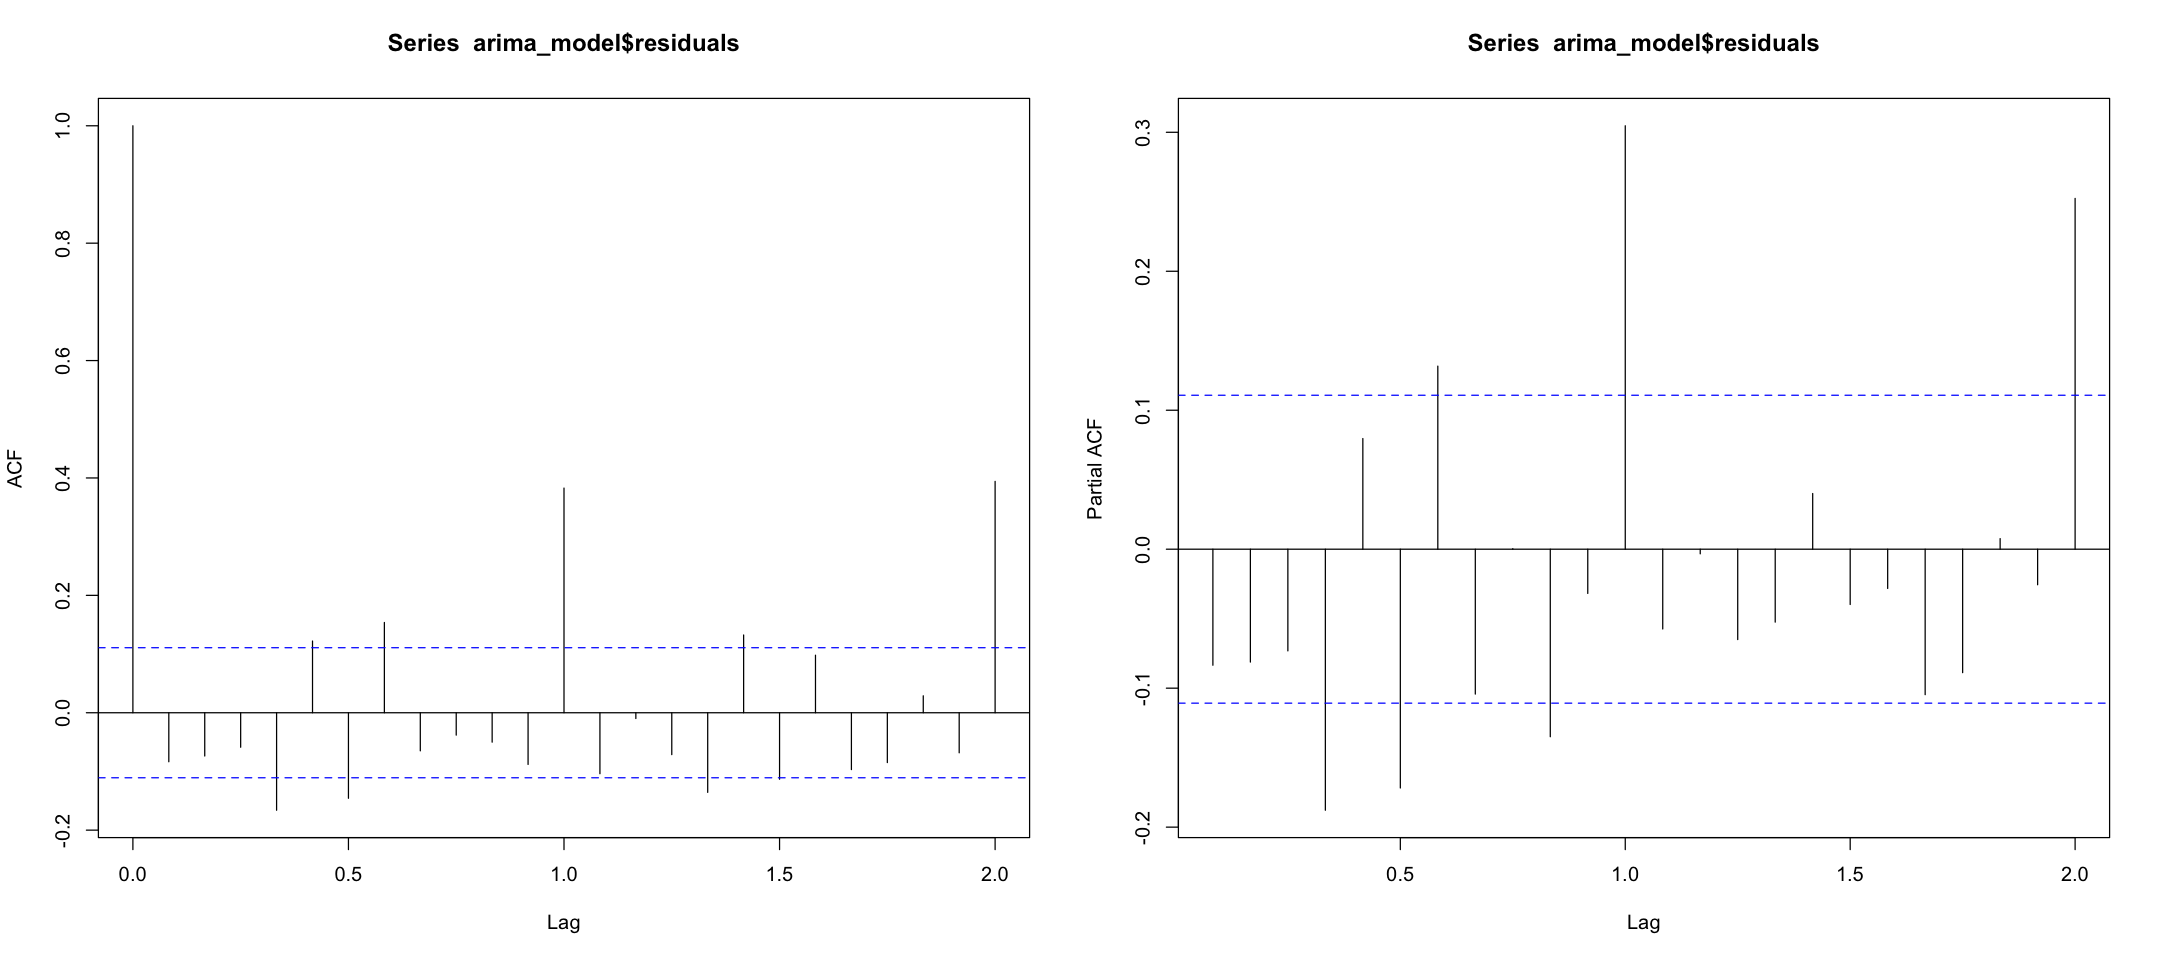

In [341]:
arima_model <- auto.arima(i_mom, ic= "bic", seasonal = FALSE)
arima_model

# diagnostics
par(mfrow = c(1, 2))
acf(arima_model$residuals)
pacf(arima_model$residuals)
shapiro.test(arima_model$residuals)
Box.test(arima_model$residuals, lag = 12, type = "Ljung", fitdf = 2)

The ARMA(0,0) model with mean is automatically selected based on the BIC. The results, including the diagnostic tests, are almost identical to those of the local level model estimated by the StructTS function. In addition, the mean value is the same. Similarly, results of Shapiro-Wilk normality test and Ljung-Box test indicates normal distribution of residuals and no significant evidence for unexplained autocorrelation, respectively. The outcome of ACF and PACF plots looks suspicious. 

It follows also the procedue of local level model in terms of forecast. It only makes the mean line longer. 

Jan       Feb       Mar       Apr       May       Jun       Jul      
2022                     0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2023 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2024 0.1756093 0.1756093                                                  
     Aug       Sep       Oct       Nov       Dec      
2022 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2023 0.1756093 0.1756093 0.1756093 0.1756093 0.1756093
2024

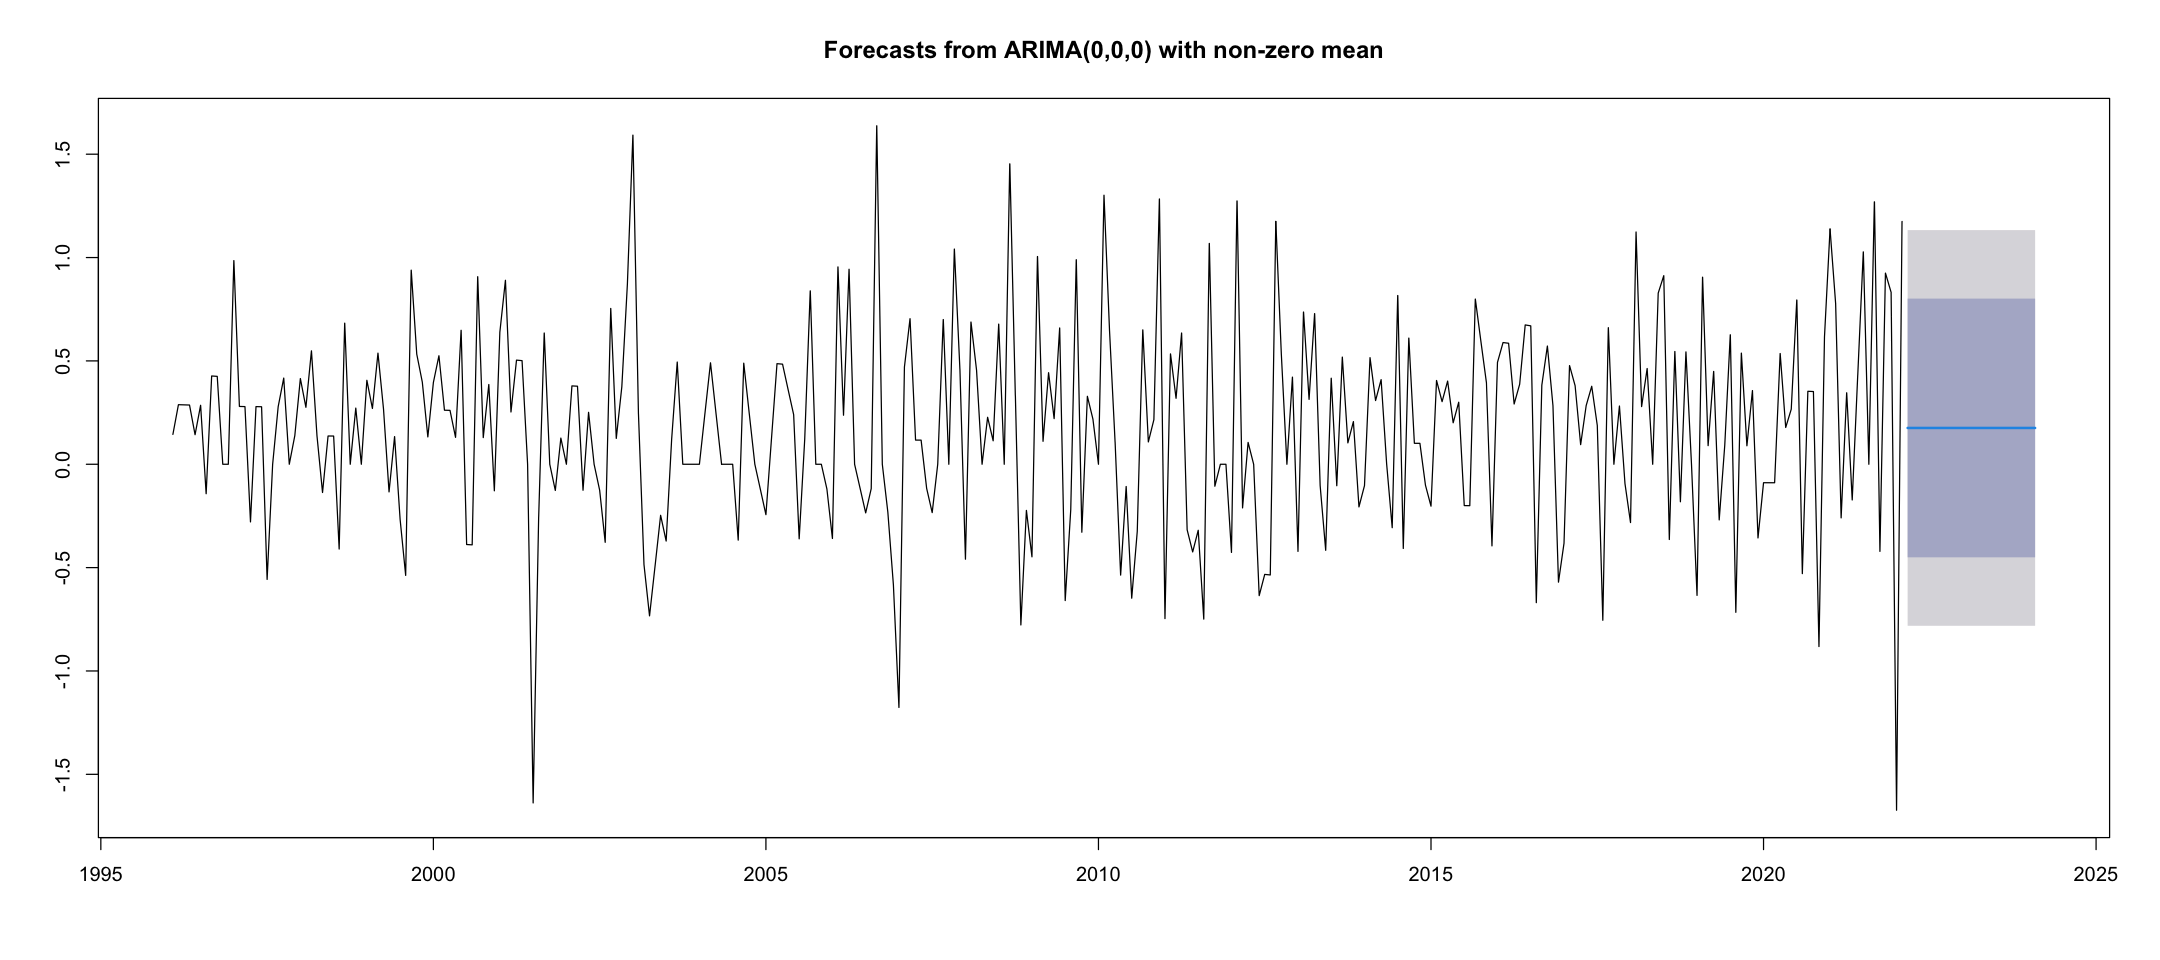

In [333]:
arima_model_f <- forecast(arima_model)
arima_model_f$mean
plot(arima_model_f)

Now, I introduce the seasonality into the model. Other arguments remains the same.

Series: i_mom 
ARIMA(0,0,0)(2,0,0)[12] with non-zero mean 

Coefficients:
        sar1    sar2    mean
      0.2716  0.3194  0.1866
s.e.  0.0566  0.0580  0.0542

sigma^2 = 0.1813:  log likelihood = -177.72
AIC=363.43   AICc=363.56   BIC=378.42


	Shapiro-Wilk normality test

data:  sarima_model$residuals
W = 0.97497, p-value = 2.845e-05



	Box-Ljung test

data:  sarima_model$residuals
X-squared = 12.574, df = 10, p-value = 0.2485


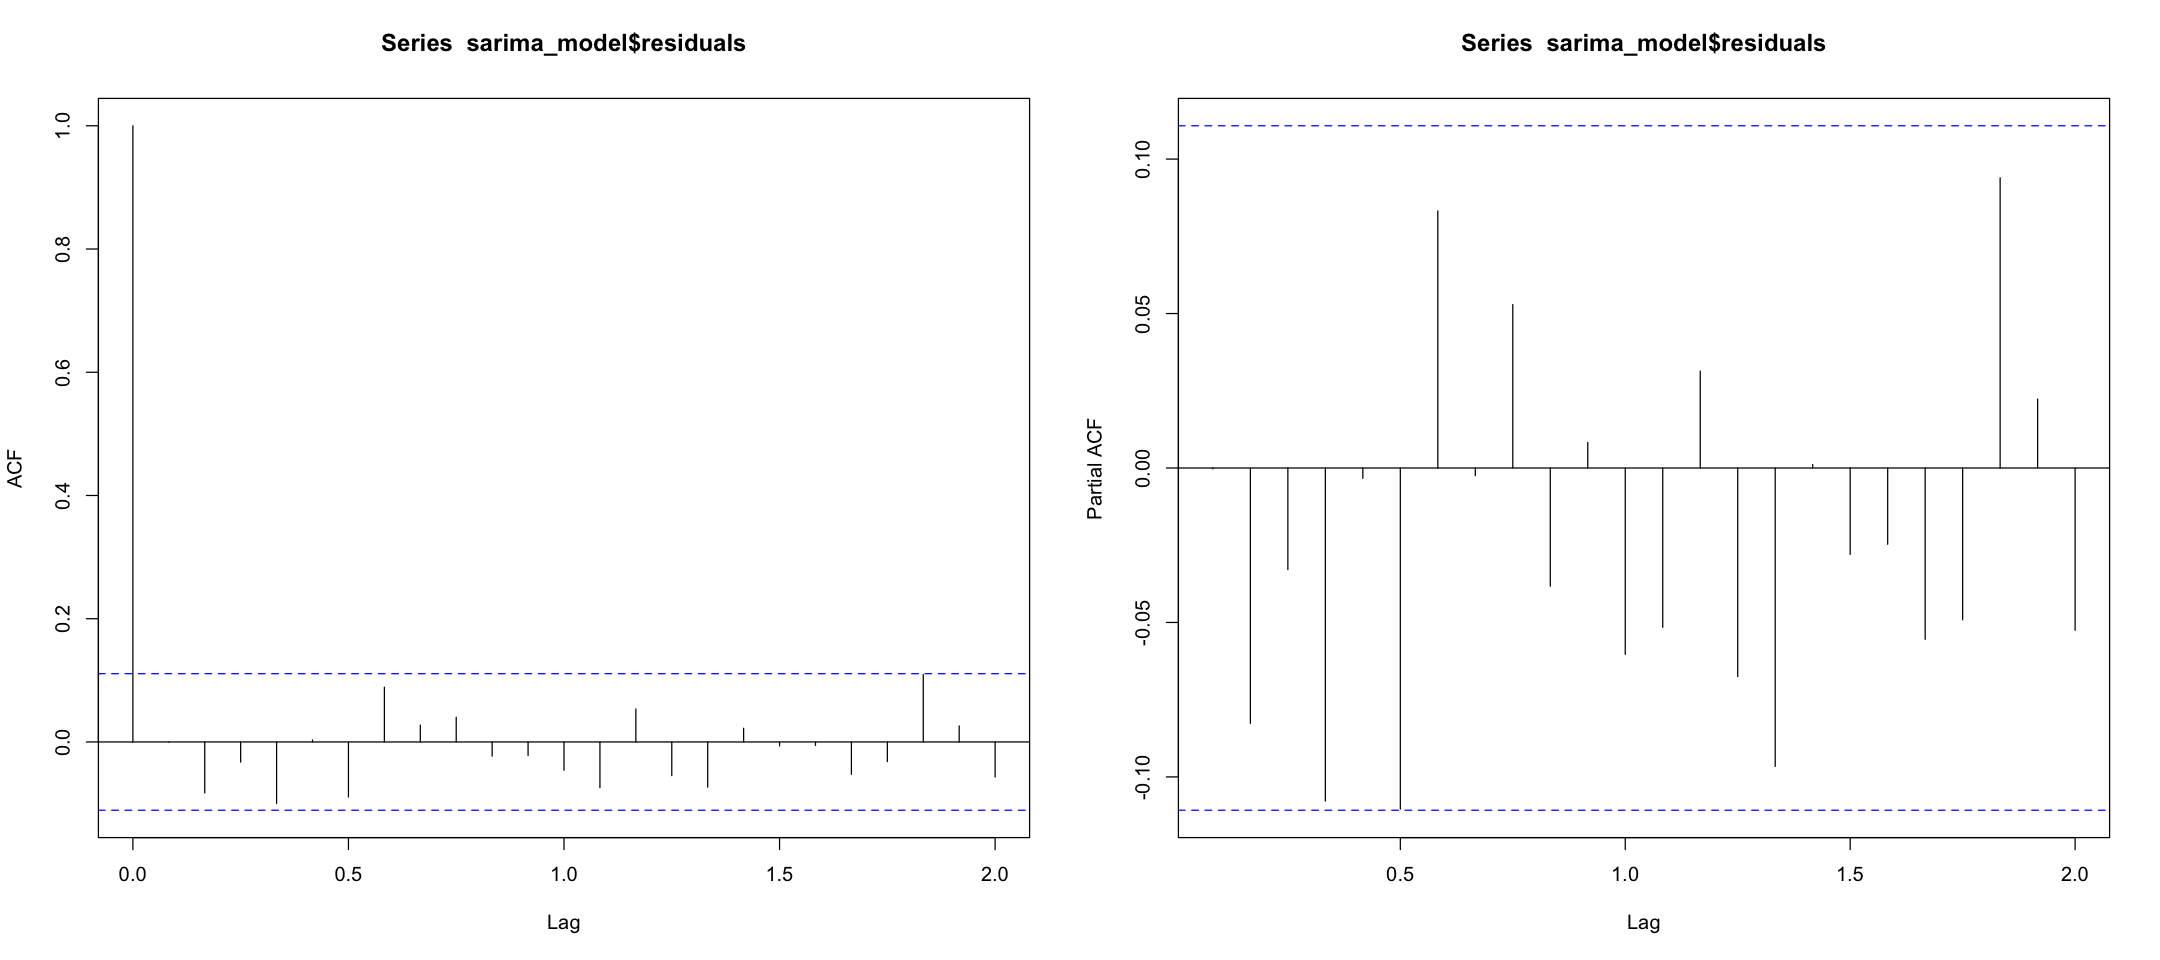

In [362]:
sarima_model <- auto.arima(i_mom, ic= "bic")
sarima_model

# diagnostics
par(mfrow = c(1, 2))
acf(sarima_model$residuals)
pacf(sarima_model$residuals)
shapiro.test(sarima_model$residuals)
Box.test(sarima_model$residuals, lag = 12, type = "Ljung", fitdf = 2)

Unsurprisignly, the ideal model detects significant cyclical pattern in data. I also perform diagnostic on residuals. They seem to be normally distributed. ACF and PACF plots do not show any significant lags. Nevertheless, the Ljung-Box test does not rejected the null hypothesis that some unexplained autocorrelation is present in residuals. From thsi perspective, the Kalman Filter model provides better estimation.

Jan         Feb         Mar         Apr         May         Jun        
2022                         -0.02273006  0.34135367  0.08624192  0.27852160
2023 -0.01483959  0.64459055 -0.01271869  0.27947676  0.04457426  0.28972058
2024 -0.46234248  0.62658937                                                
     Jul         Aug         Sep         Oct         Nov         Dec        
2022  0.60925355 -0.09269507  0.53395784  0.07422621  0.04582742  0.50012495
2023  0.57000068  0.05113852  0.62690918 -0.03813164  0.38416708  0.47836561
2024

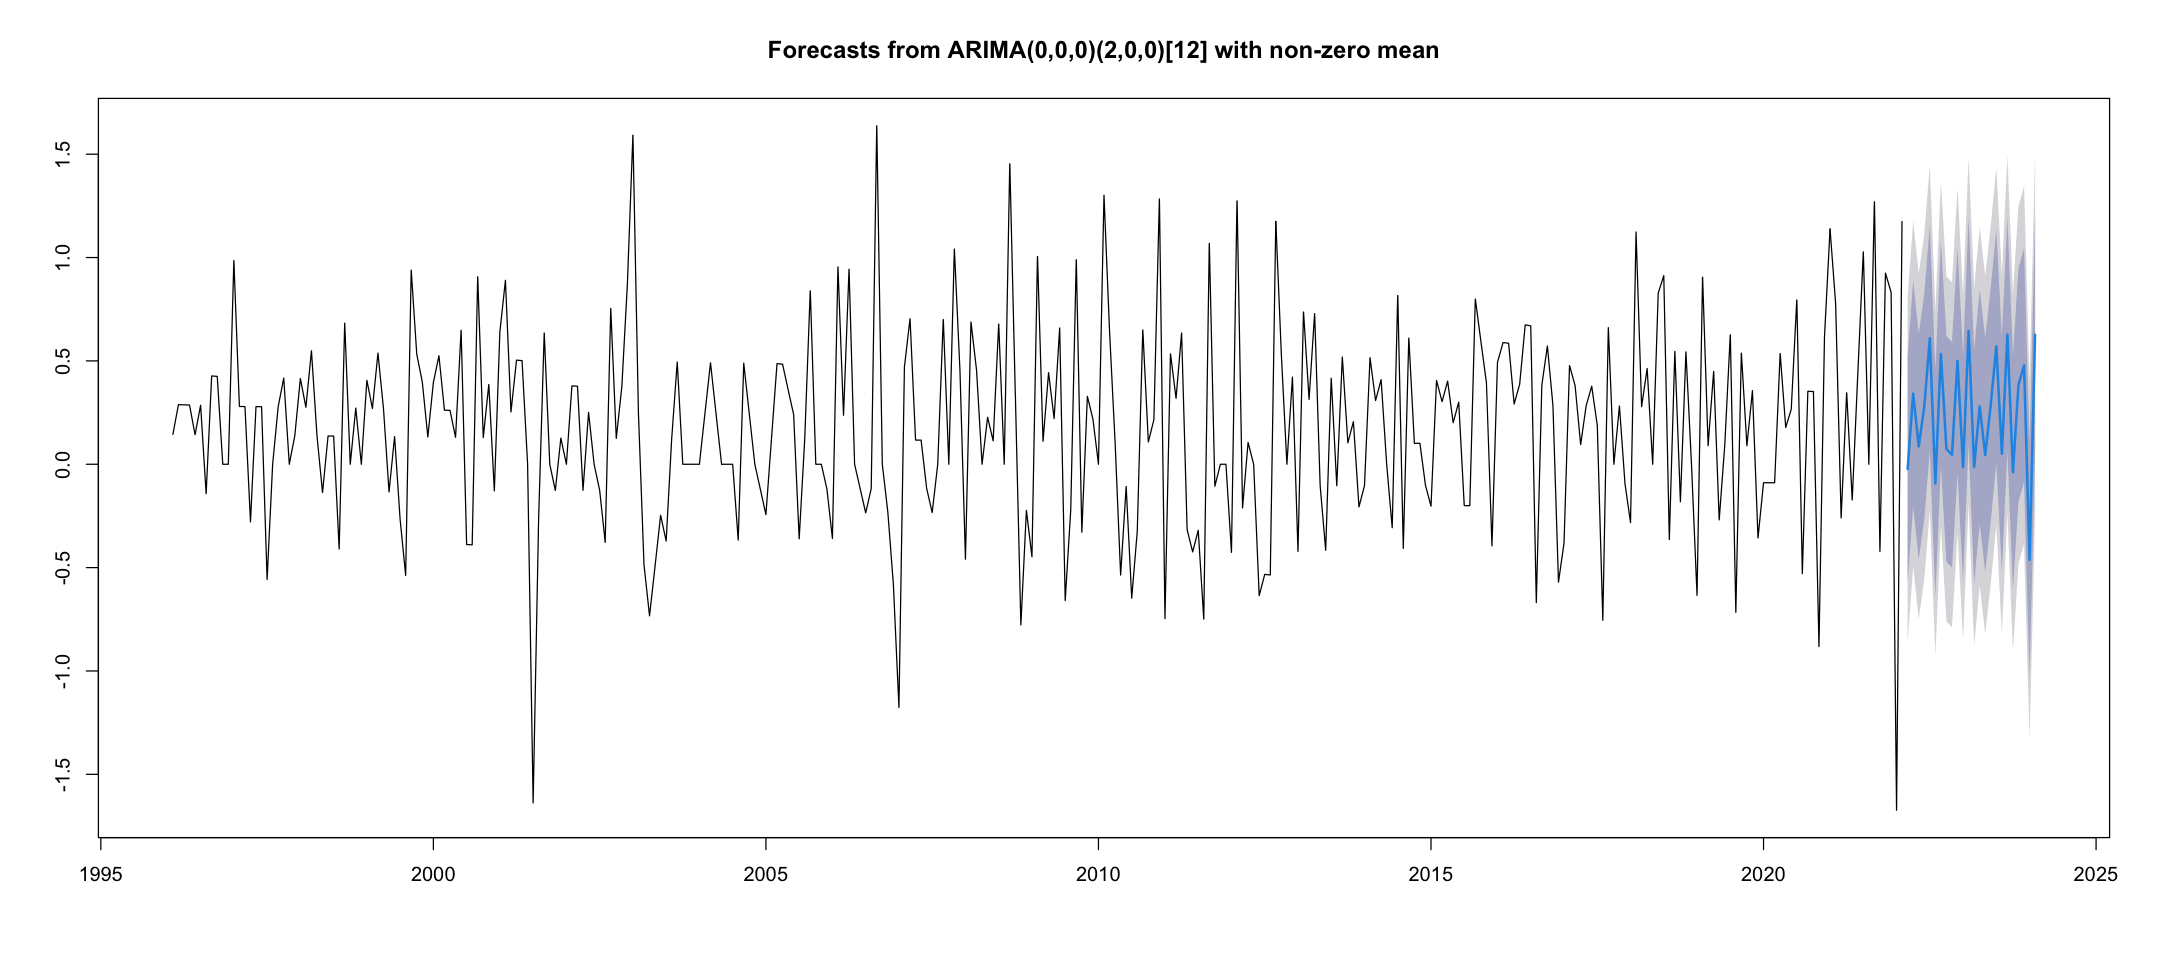

In [332]:
sarima_model_f <- forecast(sarima_model)
sarima_model_f$mean
plot(sarima_model_f)

The SARIMA model produce similar fit to Kalman Filter model. Below, I compare the predictions. I plot also 80% confidenc eintervals of the models. The forecast of SARIMA model mean prediciton seems to be sligthly flatter. That may be the reason why some autocorrelation may be unexplained. On the other hand, both mean predictions fall into all confidence intervals. 

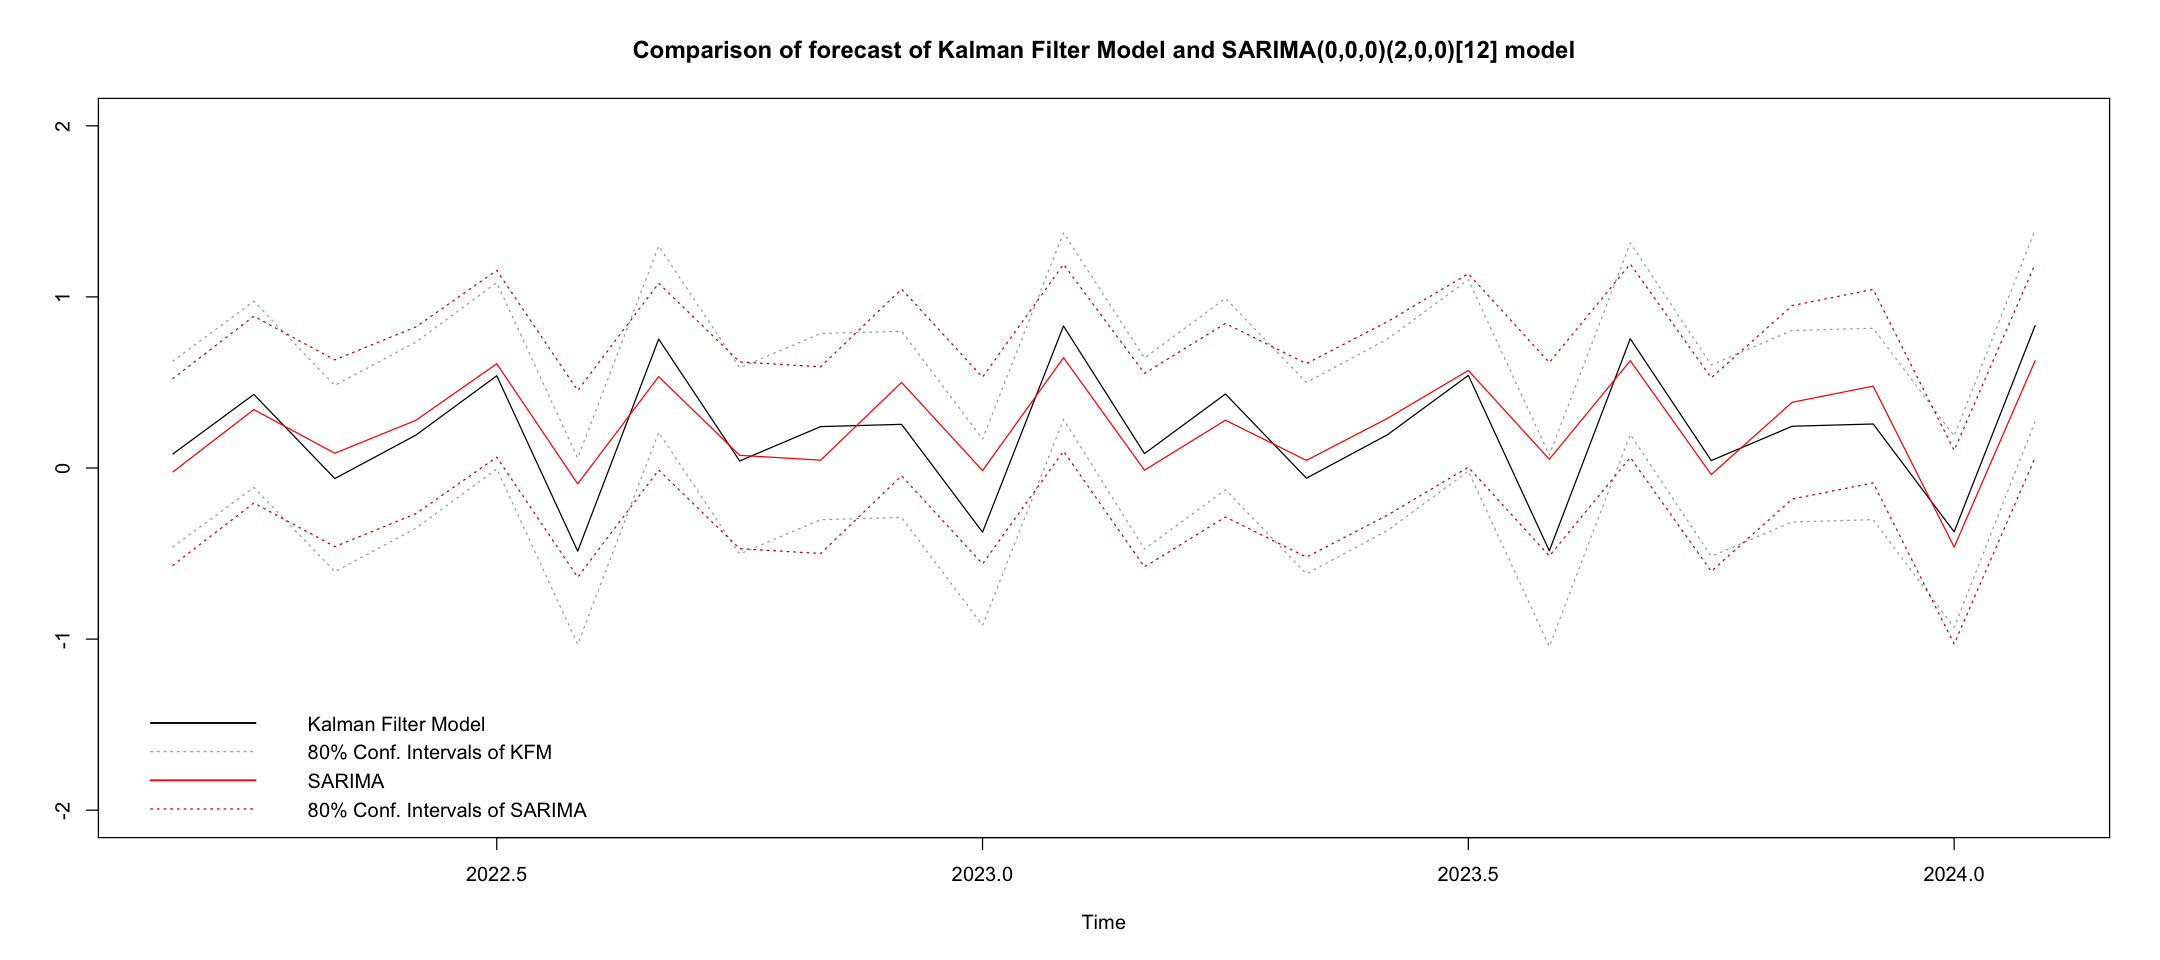

In [363]:
plot(bs_model_f$mean, ylim = c(-2,2), main ="Comparison of forecast of Kalman Filter Model and SARIMA(0,0,0)(2,0,0)[12] model", ylab="")
lines(bs_model_f$lower[,1], col = "darkgrey", lty = "dotted")
lines(bs_model_f$upper[,1], col = "darkgrey", lty = "dotted")
lines(sarima_model_f$mean, col = "red")
lines(sarima_model_f$lower[,1], col = "red3", lty = "dotted")
lines(sarima_model_f$upper[,1], col = "red3", lty = "dotted")
legend("bottomleft", legend = c("Kalman Filter Model", "80% Conf. Intervals of KFM" , "SARIMA", "80% Conf. Intervals of SARIMA"), 
       lwd = c(1.5, 1), col = c("black", "darkgrey", "red", "red3"), lty=c("solid", "dotted","solid", "dotted"), bty = "n")

To conclude, I would prefer the output from Kalman Filter because performed diagnostic tests on the residuals suggest that there is no unexplained autocorrelation. Kalman filter may be applied to to any state space model, including ARIMA. It is common to use the Kalman filter to fit an ARIMA model. Therefore, I assume Kalman Filter has some reason (e.g., amount of unexplained autocorrelation, etc.) not to select model more similar to the SARIMA model.